## Introduction

The **linear perceptron** is one of the first algorithms made in the field of AI. Compared to more recent methods it is fairly primitive and has several limitations. However it remains a good way of introducing students to many important concepts, and serves as a springboard for discussion of the more sophisticated approaches which overcome the perceptron's limitations.  

This notebook aims to build intuition in the iterative process of perceptrons, and how this process trains by learning $\theta$, the parameter which controls the classification. To do this we consider 2-dimensional data (which can be easily visualised), and show graphically how $\theta$ changes with each update in reaction to each datapoint. It is aimed at students who already grasp the mathematical principles of the perceptron but do not feel fully comfortable with the process.

## 0. Imports, settings, and helper functions

*-- Feel free to skip this section - either collapse this section, or scroll past it, down to section 1 --*

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
matplotlib.rcParams['text.usetex'] = True

import sklearn
import sklearn.datasets
import sklearn.cluster

import sympy as sp

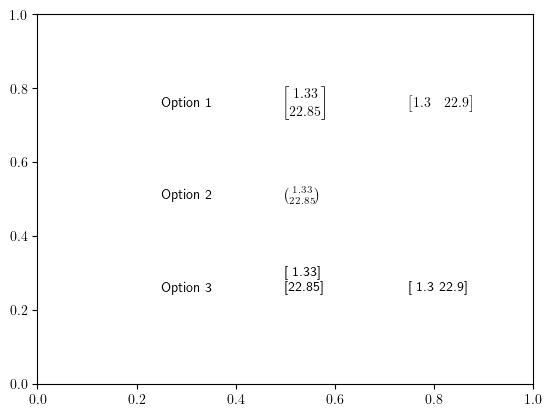

In [2]:
def pretty_vector(array, row_col='col', round_dp=2, option=1):
    '''Turns an array into a latex vector, rounded to specified dp.
    
    Turns a np array (or list etc) into a latex vector (either row or column), rounded to specified dp.
    This can then be easily displayed on a matplotlib graph as an annotation or label etc.
    
    Args:
        array       :  a numpy array or a list
        round_dp    :  how many decimal places to round the array before displaying
        option      :  Either 1, 2, or 3 - different ways of displaying the vector.
                       1 is best, 3 is worst. If 1 doesn't work, change default from 1 to 2 or 3.
    
    Returns:
        The rounded vector as a latex array for easy display on matplotlib graphs etc.
    '''
    array_ = np.round(np.array(array), round_dp).reshape((-1,1))
    if row_col=='row': 
        array_=array_.reshape((-1))

    #option #1 - best aesthetically, but most likely not to work. 
    #   Relies on matplotlib.rcParams['text.usetex'] = True
    #   Also requires matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
    if option==1:
        pretty = r'$' + sp.latex(sp.Array( array_ )) + r'$'
        return pretty

    #option #2 - medium aesthetically, but should work. Uses binomial to draw a COL vector
    #   Works with either matplotlib.rcParams['text.usetex'] = True
    #   or matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
    if option==2:
        if row_col=='col': 
            return r'$\binom{' + str(np.round(array[0], 2)) + '}{' + str(np.round(array[1], 2)) + '}$'

    #option #3 - worst aesthetically, but will definitely work, doesn't rely on latex at all
    if option==3:
        return str(array_).replace('[[', '[ ') .replace(']]', ']') 


plt.text(.25,.75, 'Option 1')
plt.text(.5,.75,pretty_vector([1.33,22.8536]))
plt.text(.75,.75,pretty_vector([1.33,22.8536], row_col='row', round_dp=1))

plt.text(.25,.5, 'Option 2')
plt.text(.5,.5,pretty_vector([1.33,22.8536], option=2))
plt.text(.75,.5,pretty_vector([1.33,22.8536], option=2, row_col='row', round_dp=1))

plt.text(.25,.25, 'Option 3')
plt.text(.5,.25,pretty_vector([1.33,22.8536], option=3))
plt.text(.75,.25,pretty_vector([1.33,22.8536], option=3, row_col='row', round_dp=1))

plt.show()

In [3]:
def pretty_theta(theta, dp=3):
    '''Turns an array of theta into a latex equality of form 'theta=vector', rounded to specified dp.
    
    Turns a np array (or list etc) into a latex equality 'theta=vector (column)', rounded to specified dp. 
    This can then be easily displayed on a matplotlib graph as an annotation or label etc.
    
    Args:
        theta       :  a numpy array or a list
        round_dp    :  how many decimal places to round the array before displaying
    
    Returns:
        The equality with rounded vector in latex for easy display on matplotlib graphs etc.
    '''
    return sp.Eq(sp.Symbol('theta'), sp.Array(np.round(theta, dp).reshape(-1,1)))

pretty_theta([1,2,3])    

Eq(theta, [[1], [2], [3]])

In [4]:
def round_nested_df(df, dp=2):
    '''Rounds all nested arrays within dataframe to specified dp.
    
    Takes a pandas dataframe with nested arrays, and returns it with all nested arrays rounded to specified dp.  
    This is useful for displaying such dataframes. 
    (Normal round methods don't work on dataframe which contain nested arrays).
    
    Args:
        df          :  a pandas dataframe containing nested arrays
        round_dp    :  how many decimal places to round the nested arrays to before displaying
    
    Returns:
        A pandas dataframe with all nested arrays rounded to specified decimal places.
    '''
    new_df = pd.DataFrame()
    for col in df.columns:
        new_df[col] = df[col].apply(lambda x : np.round(x, dp))  
    return new_df


In [5]:
#toy data, plus random shuffle function

X = np.array(
    [[-1,-1],
    [1,1],
    [1,-1],
    [1,0],
    [0.5,0],
    [-1,1]]
)
Y = np.array([1,1,-1,-1,-1, 1])


def random_shuffle(X, Y):
    '''Given a dataset X with corresponding labels Y, shuffles them randomly.
    
    Args:
        X           :  the dataset
        Y           :  the data labels.
    
    Returns:
        X, Y where 
            X       :  the shuffled dataset
            Y       :  the correspondingly shuffled data labels.

    Raises:
        ValueError  : if X and Y don't have the same length.
    '''
    if len(X) != len(Y):
        raise ValueError('X and Y must have the same length; here, X.shape='+str(X.shape) + ' but Y.shape='+str(Y.shape))
    idxs = np.arange(len(X))
    np.random.shuffle(idxs)
    return X[idxs], Y[idxs]

random_shuffle(X, Y)

(array([[ 1. , -1. ],
        [-1. , -1. ],
        [ 0.5,  0. ],
        [ 1. ,  0. ],
        [ 1. ,  1. ],
        [-1. ,  1. ]]),
 array([-1,  1, -1, -1,  1,  1]))

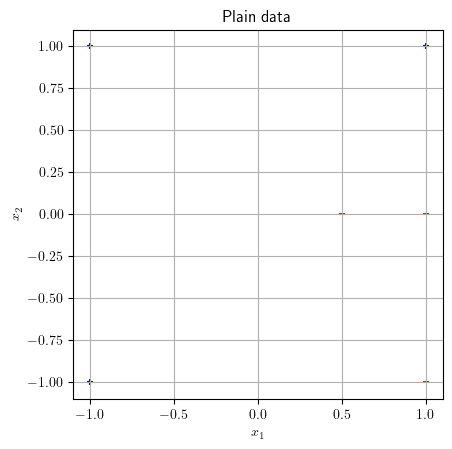

In [6]:
def plot_data_on_ax(X, Y, ax=None, alpha=1):
    '''Given a dataset X with corresponding labels Y, plots the data prettily.
    
    Args:
        X           :  the dataset
        Y           :  the data labels
        ax          :  axis to plot on. If not given, creates new axis

    Returns:
        ax          :  the axis with data plotted.
    '''

    if ax==None:
        fig, ax = plt.subplots()

    ax.scatter(X[Y== 1,-2], X[Y== 1,-1], c='blue', marker='+', s=20, alpha=alpha)
    ax.scatter(X[Y==-1,-2], X[Y==-1,-1], c='red', marker='_', s=20, alpha=alpha)

    ax.grid(which='major')

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    # we need to set the aspect of both dimensions equally, 
    # i.e. one unit in the x direction will be as long as one unit in the y direction.
    # This is important so that circles drawn on the plot appear like circles, 
    # and so that the theta arrow can be seen to be perpendicular to the dividing line.
    ax.set_aspect('equal', adjustable='box')

    return ax


ax = plot_data_on_ax(X, Y)
ax.set_title('Plain data')
plt.show()

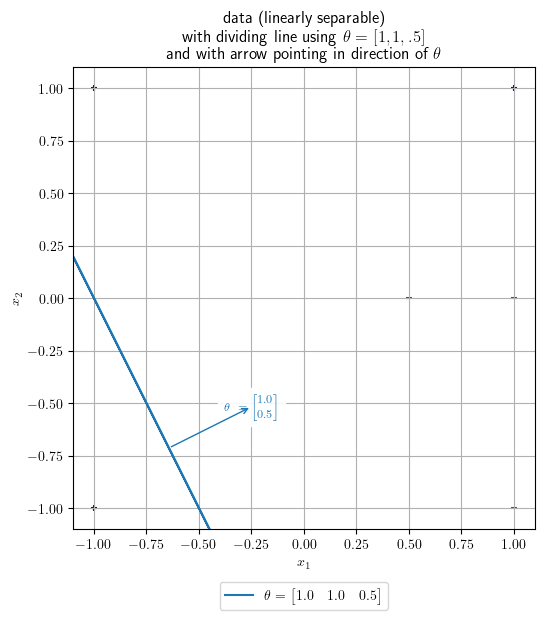

In [7]:
# make a list of basic colours which can be cycled through
colours_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_dividing_line_and_theta_arrow_on_ax(theta, ax, num_mistakes='', i='', X_i='', t='', ls='-'):
    '''Displays the classifier described by theta on the ax.
    
    Visually shows theta in three ways:
        1) by drawing the dividing line on the boundary of the classifier
        2) with an arrow in the direction of theta - direction is the main thing to show
            (length of the arrow is made dependent on ax size, so it will always be easily visible)
        3) by annotating the arrow with the value of theta.

    Args:
        theta       :  theta which defines the classifier. 
                        For 2d data - an array of length 2 (if passes through origin) or 3 (if intercept is allowed).
                        Theta is normal to the dividing line.
        ax          :  axis to plot on. 
        num_mistakes:  the number of mistakes the algorithm has made so far
                        (if specified, controls colour, as well as line label and theta annotation)
        i           :  the i of the ith datapoint which caused the update
                        (if specified, is mentioned on line label)
        X_i         :  the actual ith datapoint which caused the update
                        (if specified, is mentioned on line label)
        t           :  the update happened in the t'th iteration (0-indexed)
                        (if specified, is mentioned on line label)

    Returns:
        dividing_line, theta_arrow, theta_text  :
                        the three additions made to the ax are returned, in case they need to be modified.
    '''

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # work some stuff out for the dividing line
    # we basically need to know when the dividing line will leave the current axes, i.e. be outside the xlim or ylim
    # (we need this so that the perpendicular theta arrow can be placed starting on the line within the axes)
    y_computed = - ((theta[0] if len(theta)==3 else 0)        # if theta has three numbers in it, that means there should be an intercept
                    + theta[-2] * np.array(xlim)
                    )  /  theta[-1]

    x_computed = - ((theta[0] if len(theta)==3 else 0)        # if theta has three numbers in it, that means there should be an intercept
                    + theta[-1] * np.array(ylim)
                    )  /  theta[-2]

    xs = np.array([xlim[0],          xlim[1],        x_computed[0],  x_computed[1]])
    ys = np.array([y_computed[0],    y_computed[1],  ylim[0],        ylim[1]])


    # find which of those co-ordinates fall within the plot of the current axes, i.e. are inside both the xlim and ylim
    coords_within_plot = np.array([i for i in range(len(xs)) if (xlim[0]<=xs[i]<=xlim[1] and ylim[0]<=ys[i]<=ylim[1])])

    # choose a unique colour for the dividing line, theta arrow, and theta text
    colour = colours_cycle[num_mistakes%len(colours_cycle)] if num_mistakes!='' else colours_cycle[0]

    if len(coords_within_plot)==2:          # i.e. if the dividing line goes through the plot (usually does), then plot theta arrow and theta text
    #  (if theta[0]!=0 and theta[1] and theta[2] are small, then the dividing line may not go through plot at all - in which case don't try to plot)
    
        # work some stuff out for the theta arrow
        # we randomly choose a location near the centre of the dividing line for the start of the arrow
        # arrow_start_x = np.random.normal(loc=np.mean(xs[coords_within_plot]))
        range_x = np.max(xs[coords_within_plot]) - np.min(xs[coords_within_plot])
        arrow_start_x = np.random.uniform(np.min(xs[coords_within_plot])+range_x*.15,   np.max(xs[coords_within_plot])-range_x*.15)
        arrow_start = np.array([arrow_start_x, 
            - ((theta[0] if len(theta)==3 else 0)        # if theta has three numbers in it, that means there should be an intercept
                        + theta[-2] * arrow_start_x
                        )  /  theta[-1]])

        # the end of the arrow is found by taking the start, plus :
        #   a normalised theta (so the theta arrow will always have length 1 - otherwise you can get very long arrows),
        #        times the size of the plot times 0.2 (so the theta arrow will always have length 0.2 the size of the plot - otherwise you can get very long arrows),
        arrow_end = arrow_start + ( (theta[-2:] / np.sum(theta[-2:]**2)**.5)  * 0.2*(xlim[1]-xlim[0])  )

        # Plot the theta text
        theta_text = ax.annotate(text=r'$ {\Huge  \theta_{' + str(num_mistakes) + r'}}   \ = \ $' + pretty_vector(theta[-2:]),
            backgroundcolor='w', color=colour, #dividing_line[0].get_color(), 
            xy=arrow_end,  va='center', ha='center', size='small',  )
        # make the background of the text whiteish so underlying datapoints can still be seen dimly but don't obscure the text
        theta_text.set_bbox({'facecolor':'white', 'edgecolor':'white', 'alpha':0.9})

        # Plot the theta arrow, starting somewhere on the dividing line, pointing in the direction of theta (note: scale not preserved)
        theta_arrow = ax.annotate(text='', xy=arrow_start, xytext=arrow_end, 
            arrowprops={'arrowstyle':'<-', 'color':colour, 'ls':ls},)

    else: theta_arrow, theta_text = None, None


    # Plot the dividing line. Note: we do this even if the dividing line DOESN'T go through the plot, so it will appear on the legend
    label = (r'$\theta_{' + str(num_mistakes) + r'} = $ ' + pretty_vector(theta, 'row')
        + ((': after ' + str(num_mistakes) + ' mistakes ' ) if num_mistakes!='' else '')
        + (('\tin iteration \#' + str(t) + ' ') if t!='' else '')
        + (('\tas a reaction to datapoint $x^{(' + str(i) +')} = $' + pretty_vector(X_i, 'row')) if i!='' else '')
        )
    if len(coords_within_plot)<2:  
        label += '\n(NB Line is outside the bounds of the plot)'
    # dividing_line = ax.plot(xs[coords_within_plot], ys[coords_within_plot], c=colour, label=label)
    dividing_line = ax.plot(xs, ys, c=colour, ls=ls, label=label)


    # reset xlim and ylim to original (otherwise plt makes them bigger, to make a margin around the plotted dividing line)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    return dividing_line, theta_arrow, theta_text


# plot data and theta
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6,6))
plot_data_on_ax(X, Y, ax)
# dividing_line, theta_arrow, theta_text = plot_dividing_line_and_theta_arrow_on_ax(theta+np.array([0,1,-3], ax=ax), num_mistakes=22, ls=':')# xlim=(-2,4), ylim=(-2,3))
dividing_line, theta_arrow, theta_text = plot_dividing_line_and_theta_arrow_on_ax(theta=np.array([1,1,.5]), ax=ax)# xlim=(-2,4), ylim=(-2,3))

ax.set_title('data (linearly separable) \nwith dividing line using $\\theta=[1,1,.5]$' #+ '$' + sp.latex(pretty_theta([1,1,1])) + '$'
    + '\nand with arrow pointing in direction of $\\theta$')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),)
    #      fancybox=True, shadow=True, ncol=5)
plt.show()

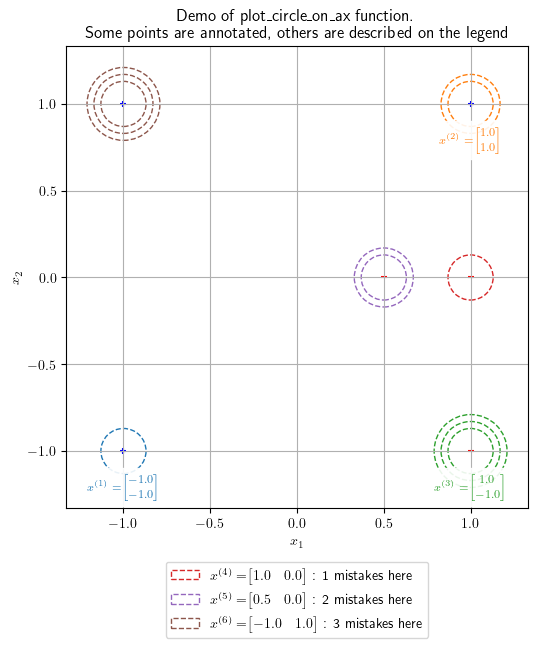

In [8]:
def plot_circle_on_ax(X_i, i, ax, circle_radius=.13, num_rings=1, colour_num='', num_mistakes='', annotation_or_legend='annotation'):
    '''Draws a circle round the i'th datapoint. Exact location of i'th datapoint is recorded in annotation or on legend.
    
    Args:
        X_i         :  the datapoint we want to circle
        i           :  the i of the ith datapoint we want to circle
        ax          :  axis to plot on
        circle_radius: radius of circle to draw
        num_rings   :  how many rings to draw around the datapoint. Default 1
        colour_num  :  which colour should be used for the circle (so will match with colour of resulting dividing line)
        num_mistakes:  the number of mistakes the algorithm has made so far (for the legend)
        annotation_or_legend: specifies whether circle should be annotated on the plot, or described on the legend.

    Returns:
        circle_list, datapoint_annotation  :
                        the two additions made to the ax are returned, in case they need to be modified.
    '''

    # choose a colour for the rings & annotation
    colour = colours_cycle[colour_num%len(colours_cycle)] if colour_num!='' else colours_cycle[0]

    # draw the circle(s) around the specified point
    if annotation_or_legend=='legend':
        label = r'$x^{(' +str(i+1) +')} = $' + pretty_vector(X_i[-2:], row_col='row')
        if num_mistakes!='':
            label += '\t : ' + str(num_mistakes) + ' mistakes here' 
    else:
        label=''

    circle_list = []
    for circle_i in range(num_rings):
        circle_list.append(plt.Circle(X_i[-2:], radius=circle_radius + circle_i/25, 
            fill=False, color=colour, linestyle='--',
            label=label if circle_i==0 else '') )
        ax.add_patch(circle_list[-1])


    # mention the specified point either as an annotation or on the plot legend
    if annotation_or_legend=='annotation':
        datapoint_annotation = ax.annotate(text=r'$x^{(' +str(i+1) +')} = $' + pretty_vector(X_i[-2:]),
            # text= str(np.round(X_i[-2:],2).reshape((-1,1)))[1:-1].replace(' [', '[') , 
            color=colour, size='small',
            xy=X_i[-2:]-np.array([0,circle_radius]),  va='top',  ha='center'               )
        datapoint_annotation.set_bbox({'facecolor':'white', 'edgecolor':'white', 'alpha':0.9})
        return circle_list, datapoint_annotation

    else:
        return circle_list, None



# plot data and theta
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6,6))
plot_data_on_ax(X, Y, ax)

for i in range(3):
    circle_list, datapoint_annotation = plot_circle_on_ax(X_i=X[i], i=i, ax=ax, circle_radius=.13, num_rings=i+1, colour_num=i)
    circle_list, datapoint_annotation = plot_circle_on_ax(X_i=X[3+i], i=3+i, ax=ax, circle_radius=.13, num_rings=i+1, colour_num=3+i, num_mistakes=i+1, annotation_or_legend='legend')

ax.set_title('Demo of plot\_circle\_on\_ax function.\nSome points are annotated, others are described on the legend')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),)
    #      fancybox=True, shadow=True, ncol=5)
plt.show()


## 1. Synthetic dataset generation  

The linear perceptron is guaranteed to converge at a valid solution, when the data is linearly separable. If the data is not linearly separable, the linear perceptron will never converge. Therefore the function to generate data must have an option which guarantees that the data will indeed be linearly separable.   

Here, `K-Means` is used as a quick way of guaranteeing linearly separability: the labels for each point are re-assigned depending on which ever cluster they are closest too. The border / decision boundary which decides which cluster to assign to is linear. Hence the generated data is guaranteed to be linearly separable.

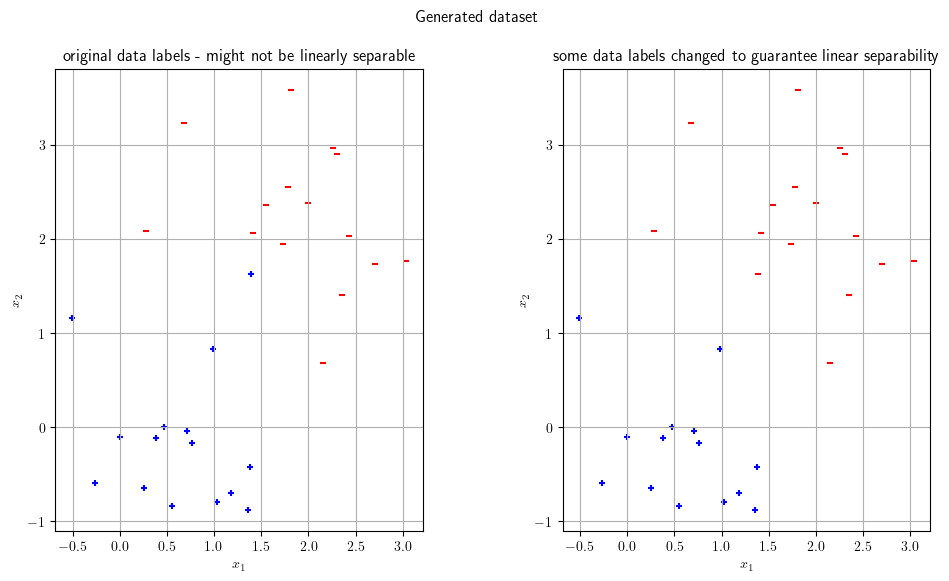

In [9]:
def generate_data(n_samples=100, linearly_separable=True, centres=None):
    '''Generates dataset for classification using perceptron algorithm or similar.
    
    Uses np.random.multivariate_normal to generate data (rather than sklearn.datasets.make_blobs), 
        as that allows more control (covariance matrix can be easily tweaked within this function if desired)
    Approx n_samples/2 points are assigned to the + cluster, and approx n_samples/2 points are from the - cluster

    Args:
        n_samples   :  the number of datapoints to generate, to be shared between the two classes
        linearly_separable:  Bool. Default True, guarantees dataset will be linearly separable
        centres     :  If specified, controls the centres of the two classes.
            If centres is not supplied, will default to (1,1) and (-1,-1)
            If centres is an array of shape 2 then that array will be added to the default centres, 
                e.g. if centres==(10,-10) then centres will be changed from (1,1) and (-1,-1) to (11,-9) and (9,-11)
            If centres is given as an array of shape 2x2 then those will be used as centres.

    Returns:
        X, Y        :  the dataset with labels.

    Raises:
        TypeError   :  If the supplied centres don't match requirements as described above.
    '''

    # blobs_approx_location = np.random.uniform(0,50, 2)
    # print(blobs_approx_location)
    # sklearn.datasets.make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=1, center_box=blobs_approx_location)

    # make cluster centres
    if type(centres)==type(None):
        centres=np.array([[ 1, 1], [-1,-1]])
    elif np.array(centres).shape==(2,):
        centres=np.array([[ 1, 1], [-1,-1]]) + np.array(centres)
    elif np.array(centres).shape==(2,2):
        pass
    else:
        raise TypeError('centres must be either None, or an array with shape (2,), or an array with shape (2,2) (see function documentation), not ' +str(np.array(centres).shape))

    # generate data
    X=np.vstack([
        np.random.multivariate_normal(mean=centres[0], cov=np.eye(2)/2, size=n_samples//2),
        np.random.multivariate_normal(mean=centres[1], cov=np.eye(2)/2, size=n_samples-(n_samples//2))
    ])
    Y=np.hstack([
        np.ones(shape=n_samples//2),
        np.ones(shape=n_samples-(n_samples//2)) * -1
    ])

    #randomly shuffle data
    X, Y = random_shuffle(X, Y)

    # if we want a linearly separable dataset, ensure it is so by changing Y according to K-Means. 
    # KMeans can be initialised using given cluster centres, and don't need many iterations
    if linearly_separable:
        Y = sklearn.cluster.KMeans(n_clusters=2, init=centres[::-1], n_init=1, max_iter=1, ).fit(X).labels_
        Y = (Y*2)-1     #make Y either +1 or -1 (instead of 0/1)
    # print(Y)

    return X, Y


np.random.seed(2)  
# When n_samples=20: seeds of 39, 58, and 64 all generate datasets which aren't linearly separable - demonstrates KMeans
# (or just set n_samples= big number and then it won't be linearly separable without KMeans for any seed)


fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6) )# sharex=True, sharey=True, )
X, Y = generate_data(n_samples=30, linearly_separable=False, centres=[[1,0], [2,2]])
plot_data_on_ax(X, Y, ax1)
ax1.set_title('original data labels - might not be linearly separable')

np.random.seed(2)  
X, Y = generate_data(n_samples=30, linearly_separable=True, centres=[[1,0], [2,2]])
plot_data_on_ax(X, Y, ax2)
ax2.set_title('some data labels changed to guarantee linear separability')

fig.suptitle('Generated dataset')

plt.show()

## 2. The Linear Perceptron algorithm
Now that the helper functions for generating data and plotting the data have been written, we can run the algorithm to deduce $\theta$. There is an entire family of solutions, as there are infinite ways in which a dividing line can be drawn. This algorithm is guaranteed to find one member of this family, i.e. one of the many possible correct solutions.  
We will then use the  helper functions for plotting the dividing line and $\theta$ arrow, and together with the `plot_data_on_ax` function, this will be used to visualise the solution.  

Note that when `allow_intercept=True`, $X$ has a column of $1$'s prefixed to it, to allow an intercept: $\theta$ will then be of length 3, with the first value $\theta_0$ being the intercept.  
If `allow_intercept=False`, this will not be done, and so only classifiers which pass through the origin can be found. If the dataset is not fully classifiable on that basis, the algorithm will fail to converge.  
Either way, the algorithm operates in the same way.

In [10]:
def linear_perceptron(X, Y, allow_intercept=True, verbose=0, return_updates_df=False):
    '''Given a dataset X, with corresponding labels Y, runs linear perceptron algorithm to find classifier.
    
    Can either be restricted to classifiers which pass through the origin, 
    or an intercept can be allowed.
    Can record a list of all updates made as the algorithm ran.
    Runs for a maximum number of iterations as specified in `for t in range(...)`

    Args:
        X           :  the dataset
        Y           :  the data labels
        allow_intercept: if `allow_intercept==True`, classifier can have an intercept. 
                         Otherwise is restricted to passing through the origin.
        verbose     :  controls how verbose the function is.
                        can be 0 (silent), 1, or 2 (chatty) (or -1).
                        Under 0, only alerts if failed to converge (to turn that off also, set verbose=-1 - not recommended)
        return_updates_df: If `return_updates_df==True`, returns a list of all updates made until convergence.

    Returns:
        theta, updates_df
            theta          :  the result of the linear perceptron algorithm
            updates_df     :  if `return_updates_df==True`, returns a dataframe of all updates made until convergence.
    '''

    if allow_intercept:
        X = np.hstack([np.ones(shape=(X.shape[0], 1)), X])

    theta = np.zeros(shape=X.shape[1])
    num_mistakes = 0
        
    if verbose>0 : print('at the beginning, before any iterations', 'num_mistakes=', num_mistakes, 'theta', theta)

    if return_updates_df:
        updates = []

    for t in range(10**8):    # if not linearly separable it won't converge. So to prevent an infinite loop, set max iterations
        converged=True                          #tentatively assert we've reached convergence
        for i in range(len(X)):

            if Y[i] * theta @ X[i].T <= 0:
                converged=False                 # retract the assertion that we've reached convergence
                theta_prev = theta[:]

                num_mistakes += 1
                theta = theta + (Y[i] * X[i])

                if return_updates_df:
                    updates.append({'iteration':                    t+1,
                                    'mistake num':                  num_mistakes,
                                    'previous theta':               theta_prev, 
                                    'datapoint of mistake - num':   i+1,
                                    'datapoint of mistake - value': X[i], 
                                    'datapoint of mistake - label': Y[i],
                                    'agreement (<=0 for mistake)' : Y[i] * theta_prev @ X[i].T, 
                                    'new theta'     :               theta,      
                                    'agreement after update (+ve)' : Y[i] * theta @ X[i].T, 
                                    })

                if verbose>1 : print('during/after iteration', t+1, 'num_mistakes=',num_mistakes, 'theta', theta)


        if converged: 
            if verbose>0 : print('Converged after', t+1, 'iterations, in which there were', num_mistakes, 'mistakes')
            break

    if not converged: 
        if verbose>-1 : print('FAILED TO CONVERGE after', t+1, 'iterations, in which there were', num_mistakes, 'mistakes')


    if verbose>0 : print('at the end, after all iterations', t+1, 'num_mistakes=', num_mistakes, 'theta', theta)
    
    
    if return_updates_df:
        return theta, pd.DataFrame(updates)
    else:
        return theta

# generate data and find theta
# np.random.seed(1)  
# X, Y = generate_data(n_samples=500, linearly_separable=True, centres=[.05,0])

theta = linear_perceptron(X, Y, verbose=0, return_updates_df=False)

pretty_theta(theta)

Eq(theta, [[5.0], [-1.8], [-2.939]])

Plotting the data together with the dividing line for the above theta shows that the algorithm has succesfully found a classifier:

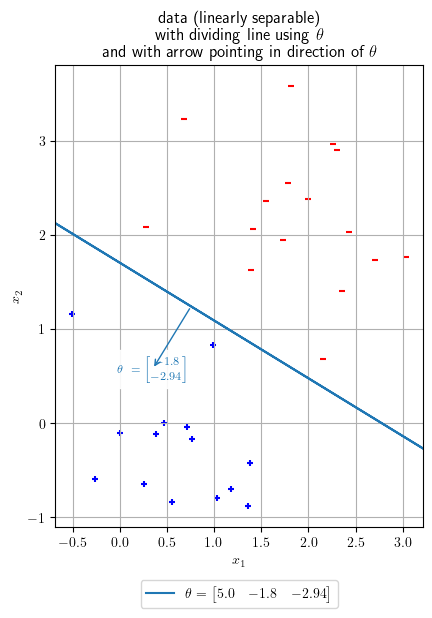

In [11]:
# plot data and theta
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6,6))
plot_data_on_ax(X, Y, ax)

dividing_line, theta_arrow, theta_text = plot_dividing_line_and_theta_arrow_on_ax(theta=theta, ax=ax)

ax.set_title('data (linearly separable) \nwith dividing line using $\\theta$' #+ '$' + sp.latex(pretty_theta([1,1,1])) + '$'
    + '\nand with arrow pointing in direction of $\\theta$')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),)
    #      fancybox=True, shadow=True, ncol=5)
plt.show()

## 3a. Developing intuition in the process: all the updates numerically

The above only shows the final classifier, using the value of $\theta$ after convergence. Now that we see it has worked, we can consider the steps of the entire process, to make it clear how each update happens, and how all the updates put together lead to a valid classifier.  

**First**, we will look at a **table of all the updates** which shows the calculations numerically. Looking at this, verify that each update follows the rule of the linear perceptron algorithm:   
$$\theta_{t} = \theta_{t-1} + y_i  x_i$$  


In [12]:
theta, updates = linear_perceptron(X, Y, verbose=0, return_updates_df=True)

round_nested_df(updates, 2)

,iteration,mistake num,previous theta,datapoint of mistake - num,datapoint of mistake - value,datapoint of mistake - label,agreement (<=0 for mistake),new theta,agreement after update (+ve)
0,1,1,"[0.0, 0.0, 0.0]",1,"[1.0, 1.36, -0.88]",1,0.00,"[1.0, 1.36, -0.88]",3.61
1,1,2,"[1.0, 1.36, -0.88]",2,"[1.0, 1.78, 2.55]",-1,-1.17,"[0.0, -0.42, -3.43]",9.47
2,1,3,"[0.0, -0.42, -3.43]",3,"[1.0, 0.47, 0.01]",1,-0.22,"[1.0, 0.05, -3.42]",1.00
3,1,4,"[1.0, 0.05, -3.42]",8,"[1.0, -0.51, 1.16]",1,-2.99,"[2.0, -0.46, -2.26]",-0.38
4,1,5,"[2.0, -0.46, -2.26]",27,"[1.0, 0.99, 0.83]",1,-0.33,"[3.0, 0.52, -1.43]",2.33
5,1,6,"[3.0, 0.52, -1.43]",28,"[1.0, 0.28, 2.08]",-1,-0.17,"[2.0, 0.25, -3.51]",5.23
6,2,7,"[2.0, 0.25, -3.51]",8,"[1.0, -0.51, 1.16]",1,-2.19,"[3.0, -0.26, -2.35]",0.41
7,2,8,"[3.0, -0.26, -2.35]",18,"[1.0, 2.15, 0.69]",-1,-0.82,"[2.0, -2.42, -3.03]",5.28
8,2,9,"[2.0, -2.42, -3.03]",20,"[1.0, 1.38, -0.42]",1,-0.06,"[3.0, -1.04, -3.46]",3.03
9,2,10,"[3.0, -1.04, -3.46]",27,"[1.0, 0.99, 0.83]",1,-0.89,"[4.0, -0.05, -2.62]",1.77


## 3b. Developing intuition in the process: visualisation of all updates in perceptron algorithm

**Secondly**, we will **graph the updates** separately. For this we will additionally use a helper function (above) which plots circles around specific datapoints and annotates them. Each update happens as a reaction to a specific datapoint which wasn't previously classified correctly, so these circles will be used to show which datapoint caused the update. And we will also use the helper function which plots the dividing line and the $\theta$ arrow.

Again, when looking through the generated graphs, verify that each update follows the rules of the linear perceptron algorithm:  
$$\theta_{t} = \theta_{t-1} + y_i  x_i$$
 \- the datapoint is either added or subtracted from $\theta$, depending on the label sign. And where there is an intercept (first value in $\theta$), either adds one or subtracts one from it, depending on the label sign.

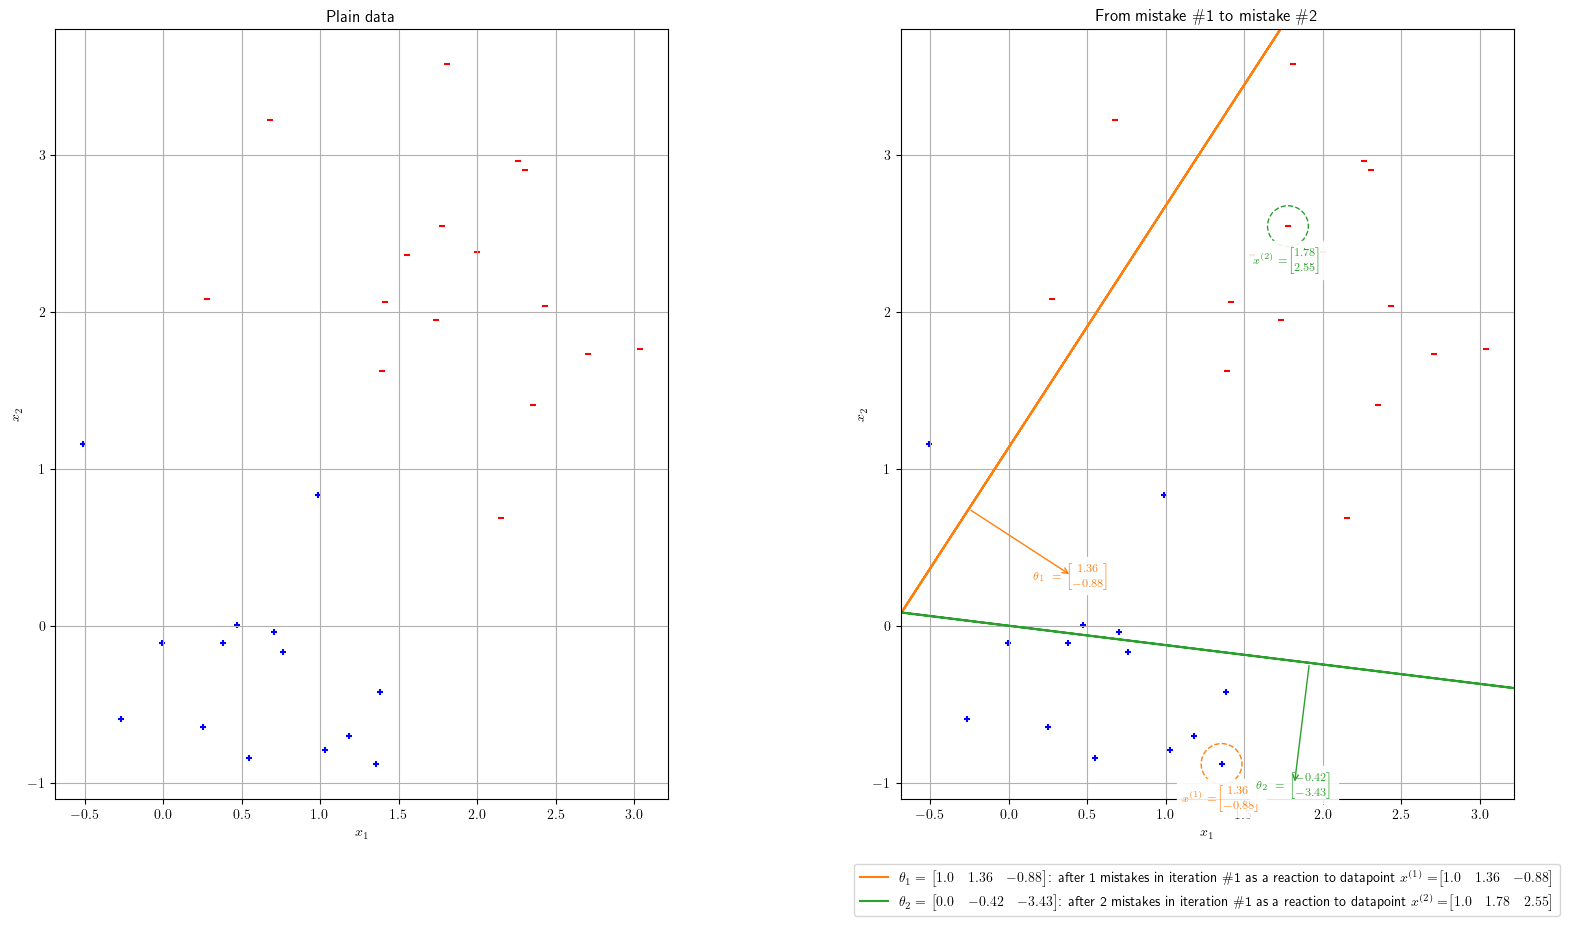

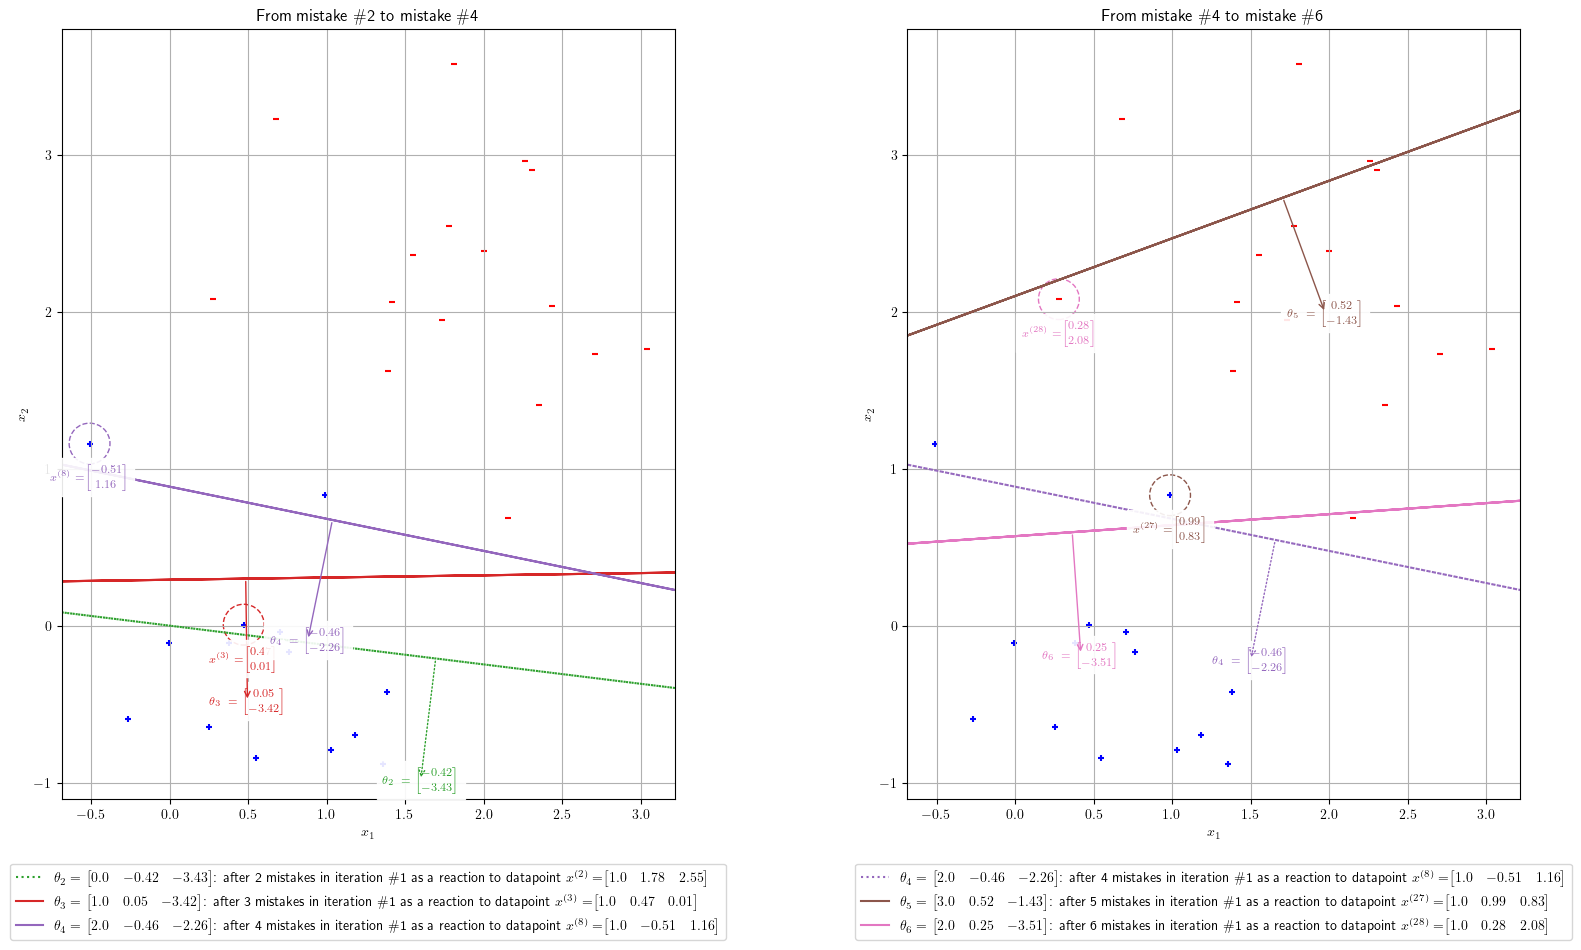

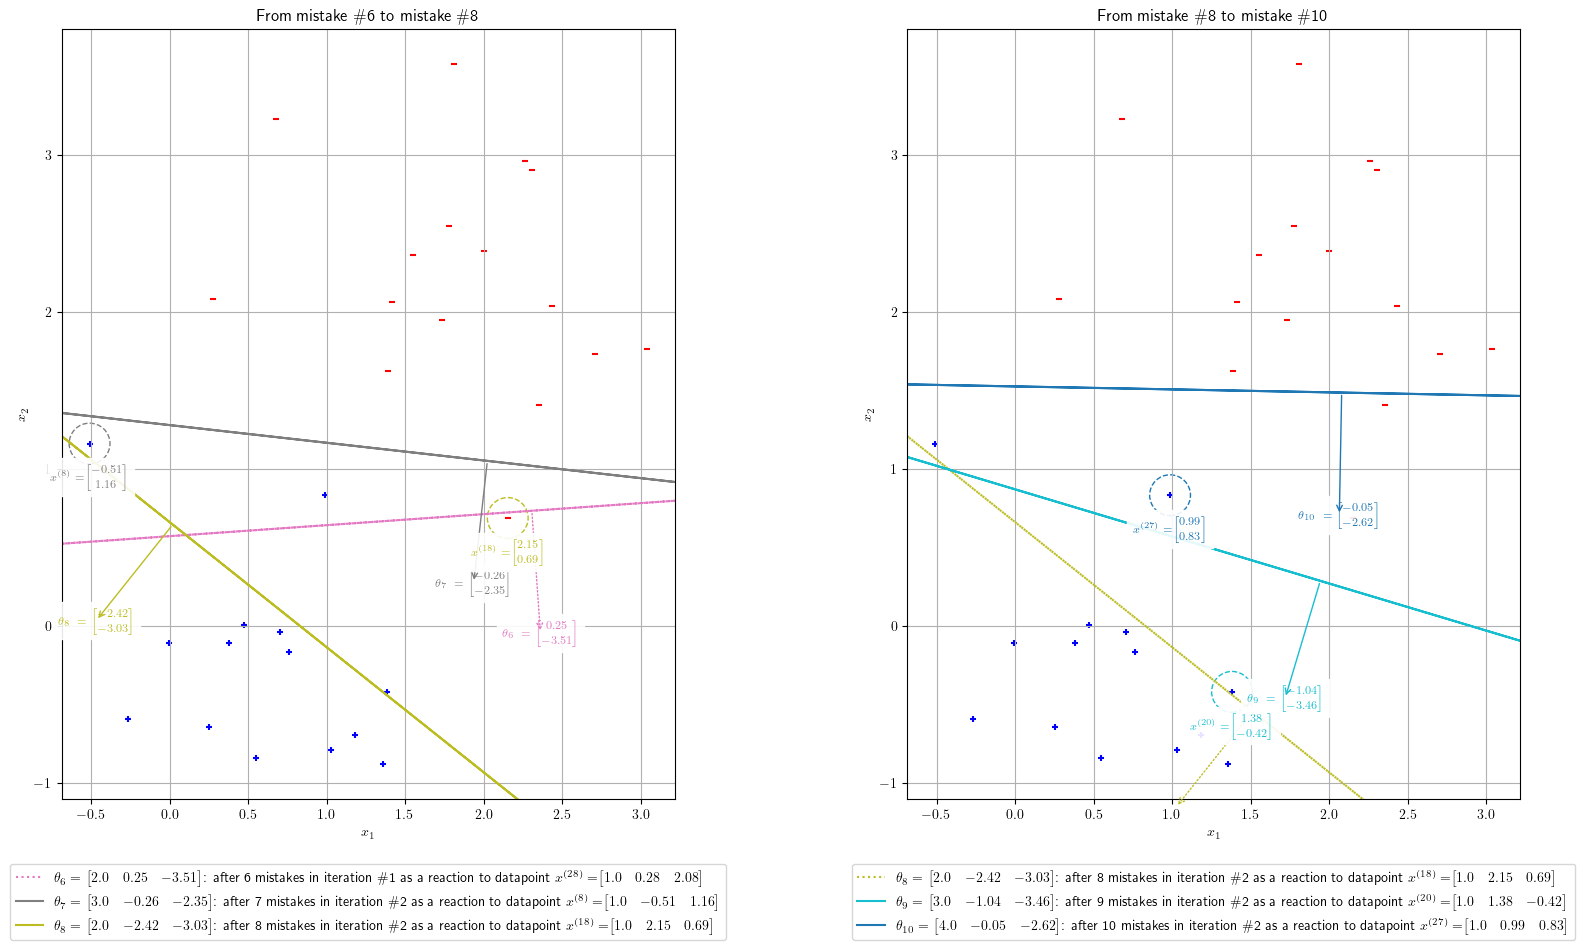

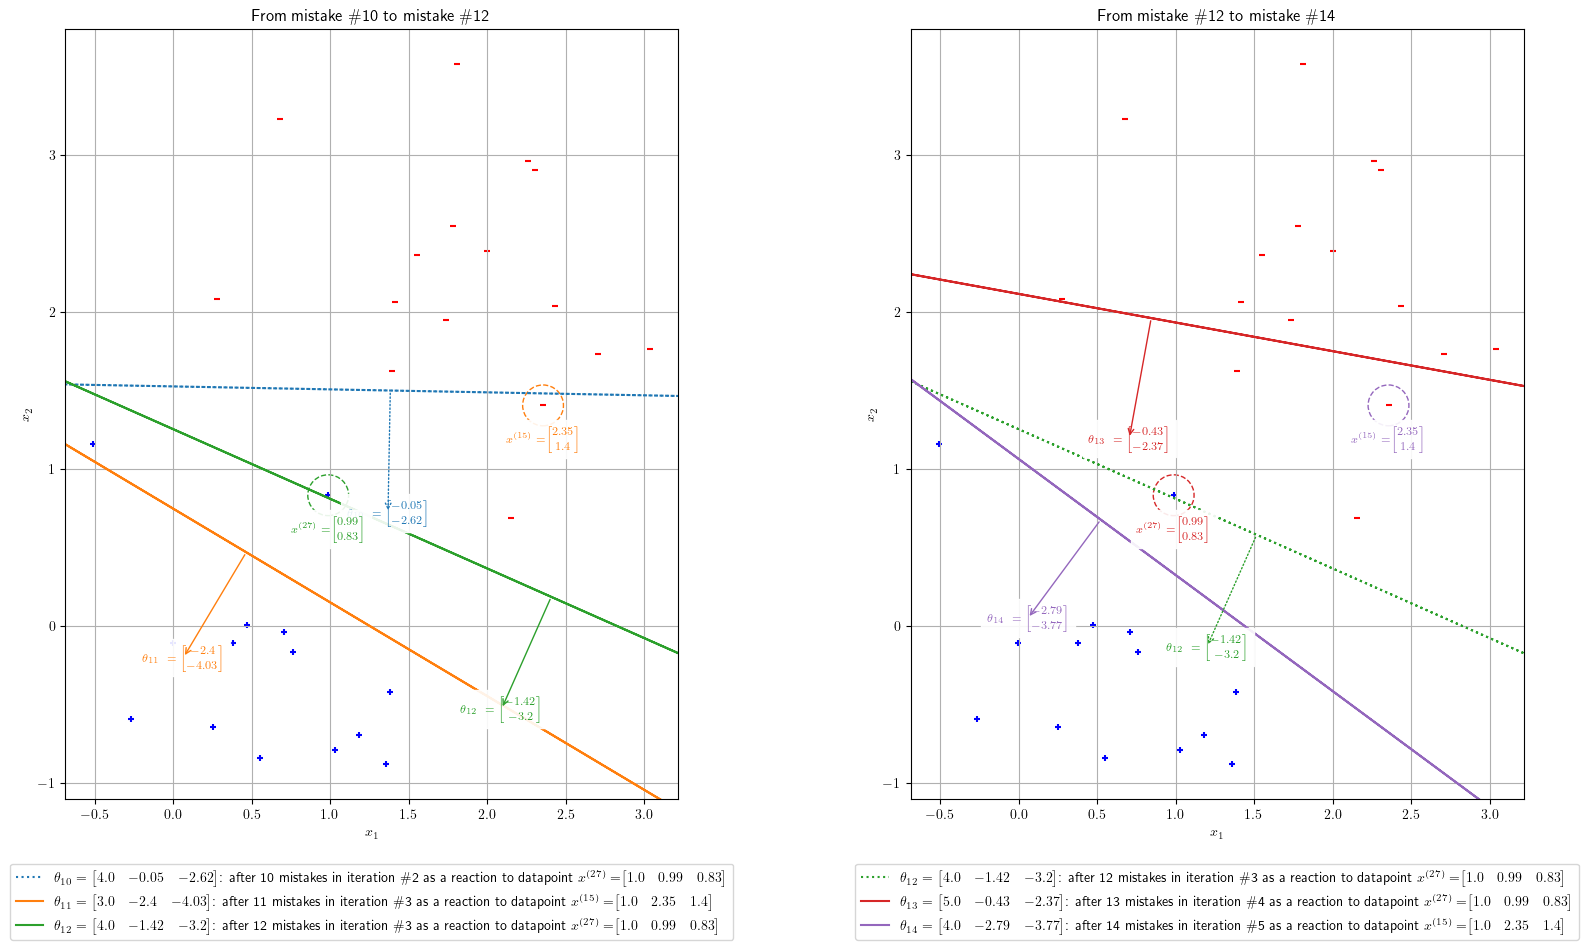

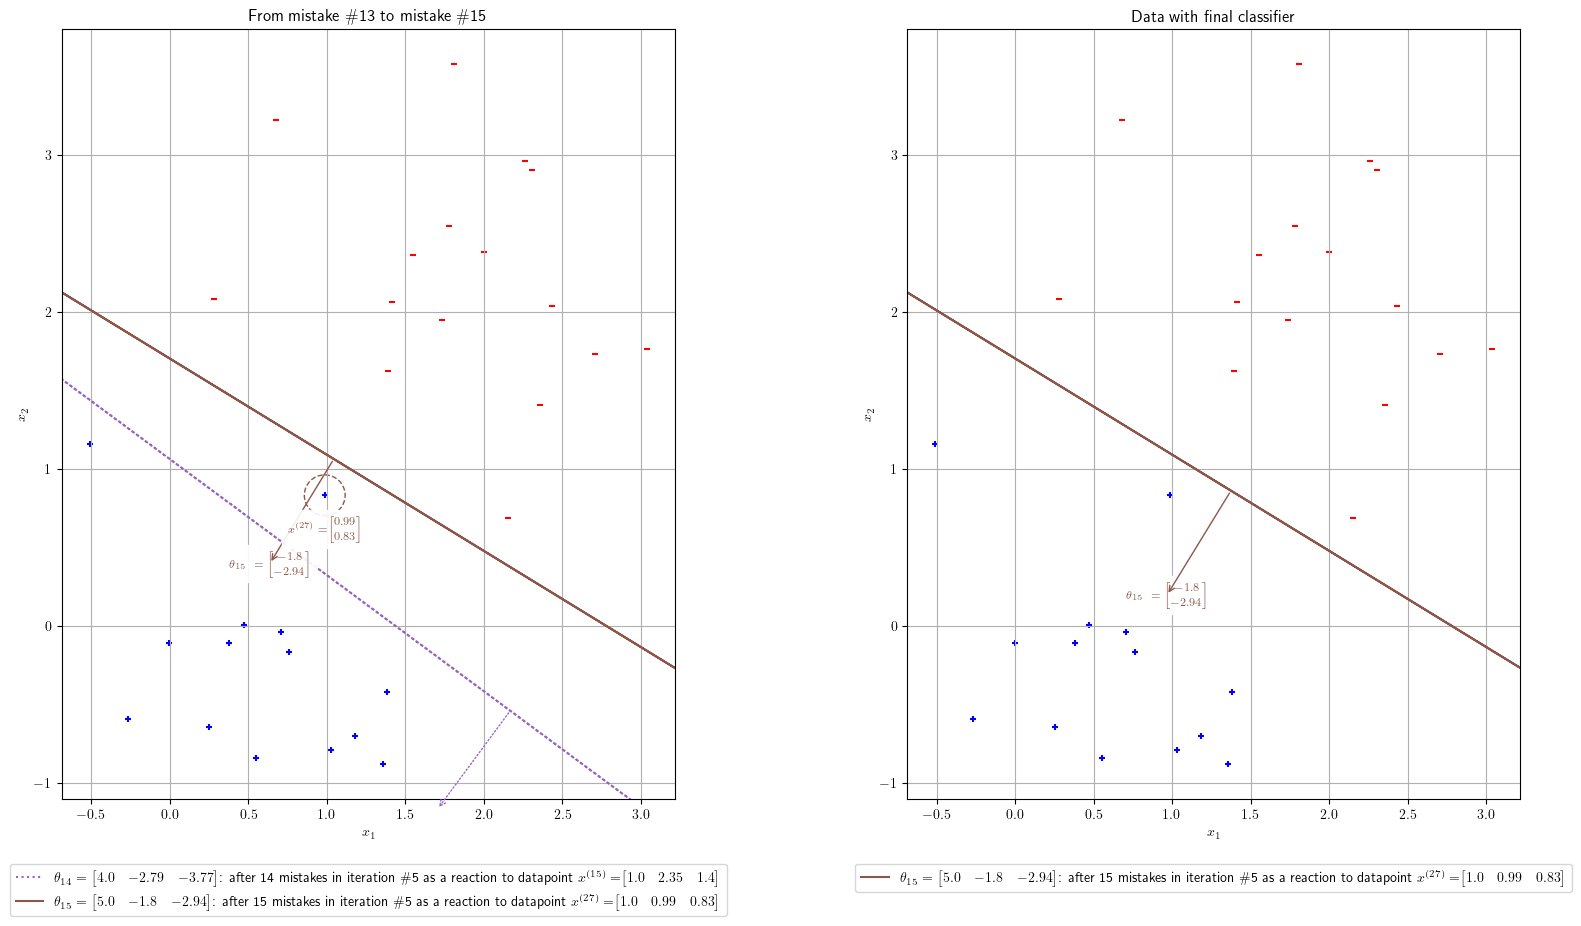

In [13]:
def plot_linear_perceptron_updates(X, Y, updates, graphic=['initial', 'final', 'iterations'], nrows=1, ncols=2, num_mistakes_per_plot=2):
    '''Plots the classifier at each stage/update of the algorithm, to show how convergence is achieved.
    
    Given a dataset X, with corresponding labels Y, and a dataframe of updates made by the linear perceptron algorithm,  
    marks the datapoints which cause each update with a circle, and plots the new dividing line, for each update.
    To make the output graphs more manageable, they are split into multiple figures, 
        with each figure containing a specified number of plots,
        with each plot showing a specified number of updates.

    Args:
        X           :  the dataset
        Y           :  the data labels
        updates     :  a dataframe of all updates made until convergence.
        graphic     :  a list of which stages of the process to display.
                        'initial'       - if in the list, plots the plain data before the algorithm is run
                        'final',        - if in the list, plots the final classifier after the algorithm completes
                        'iterations'    - if in the list, plots the classifier at each update of the algorithm.
        nrows       :  controls number of rows of axes in each figure before a new figure is started.
        ncols       :  controls number of cols of axes in each figure before a new figure is started.
        num_mistakes_per_plot : controls number of updates in each axis before a new axis is started.
    '''
    
    figsize=(ncols*10, nrows*10)
    fig = plt.figure(figsize=figsize)

    def make_new_ax_or_new_fig(fig, ax):
        '''Helper function which decides whether a new fig should be made, or whether a new ax should be added to the old fig'''

        if len(ax.get_legend_handles_labels()[0]) > 0 :                 #i.e. if there are labels on the current ax, then show them
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),)
        if len(fig.axes) == nrows*ncols:                                #i.e. if last fig is full - then show old fig, and start a new fig
            plt.show()
            fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(nrows, ncols, len(fig.axes)+1)             # add a new ax to the fig (whether old fig or new fig)
        plot_data_on_ax(X, Y, ax, alpha=1)
        num_updates_this_ax = 0
        return fig, ax, num_updates_this_ax


    if 'initial' in graphic : 
        ax = fig.add_subplot(nrows, ncols, 1)
        plot_data_on_ax(X, Y, ax)
        ax.set_title('Plain data')
        # no legend, as no dividing lines in this plot


    if 'iterations' in graphic : 

        fig, ax, num_updates_this_ax = make_new_ax_or_new_fig(fig, ax)

        for row_idx, update in updates.iterrows():
            if num_updates_this_ax >= num_mistakes_per_plot:
                fig, ax, num_updates_this_ax = make_new_ax_or_new_fig(fig, ax)

                #plot *old* dividing line and theta (from previous ax) on new ax
                if row_idx>0:
                    prev_update = updates.iloc[row_idx-1]
                    dividing_line, theta_arrow, theta_text = plot_dividing_line_and_theta_arrow_on_ax(
                        prev_update['new theta'], ax, prev_update['mistake num'], i=prev_update['datapoint of mistake - num'], 
                        X_i=prev_update['datapoint of mistake - value'], t=prev_update['iteration'], 
                        ls=':')
                
            ax.set_title('From mistake \#' + str(max(1,update['mistake num']-1-1)) + ' to mistake \#' + str(update['mistake num']-1-1+num_mistakes_per_plot) )

            #plot *new* dividing line and theta (from previous ax) on new ax
            dividing_line, theta_arrow, theta_text = plot_dividing_line_and_theta_arrow_on_ax(
                update['new theta'], ax, update['mistake num'], i=update['datapoint of mistake - num'], 
                X_i=update['datapoint of mistake - value'], t=update['iteration'])

            # and lets draw circle round point where the error happened
            circle_list, datapoint_annotation = plot_circle_on_ax(X_i=update['datapoint of mistake - value'], 
                i=update['datapoint of mistake - num'] -1, #needs to be 0-indexed
                ax=ax, circle_radius=.13, num_rings=1, colour_num=update['mistake num'])


            num_updates_this_ax += 1



    if 'final' in graphic : 
        fig, ax, _ = make_new_ax_or_new_fig(fig, ax)
        ax.set_title('Data with final classifier')

        #plot *final* dividing line and theta on new ax
        dividing_line, theta_arrow, theta_text = plot_dividing_line_and_theta_arrow_on_ax(
            update['new theta'], ax, update['mistake num'], i=update['datapoint of mistake - num'], 
            X_i=update['datapoint of mistake - value'], t=update['iteration'])

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),)# fancybox=True, shadow=True, ncol=5)

    plt.show()

    # return theta, pd.DataFrame(updates)

# generate data and find theta
# np.random.seed(1)  
# X, Y = generate_data(n_samples=500, linearly_separable=True, centres=[.05,0])

# theta, updates = linear_perceptron(X, Y, verbose=0)

theta, updates = linear_perceptron(X, Y, verbose=0, return_updates_df=True)
plot_linear_perceptron_updates(X, Y, updates)

# round_nested_df(updates, 2)

## 4. A different perspective on the perceptron algorithm

Previously, we calculated the final value of $\theta$ by updating it after each mistake according to the datapoint value and label. Final $\theta$ was then simply the value of $\theta$ after the last mistake and update.  

There is another way of calculating the final value of $\theta$. As we run the algorithm, we count the number of times a mistake is made on each datapoint. Then, at the end of the process, we can express final $\theta$ as a sum of all those datapoints multiplied by their class, and weighted by the number of mistakes made on that datapoint.  

I.e. if the number of mistakes made on the $i$'th datapoint (out of $n$ datapoints) is given by $\alpha_i$, then we can express $\theta$ as:  
$$\theta = \sum_{i=1}^n \ \alpha_i \ x_i \ y_i$$


> #### How do we get that expression?
>   
> This follows easily from the original expression for $\theta$ at each step in terms of $\theta$ at the previous step:
> $$\theta_{t} = \theta_{t-1} + y_i  x_i$$  
> If we change notation so that instead of $y_i$ and $x_i$ we have $y_{i_t}$ and $x_{i_t}$, where $i_t$ is the *index* of the datapoint on which a mistake was made in the $t$'th step, so $x_{i_t}$ is the actual datapoint of the mistake and $y_{i_t}$ is its label. Then we restate 
> $$\theta_{t} = \theta_{t-1} + y_{i_t}  x_{i_t}$$  
> and can then replace $\theta_{t-1}$, giving
> $$\theta_{t} = (\theta_{t-2} + y_{i_{t-1}}  x_{i_{t-1}}) + y_{i_t}  x_{i_t}$$  
> and so on recursively, eventually expressing $\theta$ as a sum over all the updates from the $t$ steps:
> $$\theta_{t} = \sum_{s=1}^t y_{i_s}  x_{i_s}$$  
> 
> That is looking at it in terms of the single updates from each of the $t$ steps. We can now change to looking at each datapoint, i.e. summing over all $n$ datapoints according to the count of how often they caused an update:
> $$\theta_{t} = \sum_{i=1}^n \ y_{i} \ x_{i} \ \alpha_{i} \ \ \ \  \text{where} \ \ \alpha_{i} = \sum_{s=1}^t [i_s = i] = \text{count(mistakes made on datapoint i)}$$  
> (using Iverson bracket notation, so that $\alpha_{i}$ is simply the count of times the $i$'th datapoint causes a mistake).
>   

This perspective is useful mostly when using kernels for non-linear classification with the perceptron. However in terms of visualising the algorithm, this perspective gives us a new way of inspecting what is happening, and in a more concise manner than the previous one.

Programatically, we group the updates by the datapoint which caused the update, and compute the count for that grouping. We can then create a new column which calculates the effect of each datapoint on the final $\theta$, by multiplying the datapoint with its label and by its count, i.e. $\text{Effect of datapoint} \ i = \ y_{i} \ x_{i} \ \alpha_{i}$. Then, final $\theta$ is simply the sum of that new column:

In [14]:
def summarise_most_significant_datapoints(updates):
    '''Creates a dataframe of all the points which caused mistakes and therefore affected theta.
    
    Given a list of updates made by the linear perceptron algorithm, groups the updates by the datapoint which caused them.
    Returned Dataframe states number of mistakes made on each datapoint, and the affect it therefore had on final theta.
    
    Args:
        updates     :  a dataframe of all updates made until convergence

    Returns:
        final_theta_new_perspective, importance_of_each_datapoint
            final_theta_new_perspective  :  the result of the linear perceptron algorithm, calculated the new way
            importance_of_each_datapoint :  a dataframe of all datapoints which caused updates, and how many times,
                                            and how the datapoint therefore affected the final theta.
    '''

    updates['datapoint of mistake - value'] = updates['datapoint of mistake - value'].apply(tuple)  #so it will be hashable for the groupby
    importance_of_each_datapoint = updates[['datapoint of mistake - num', 'datapoint of mistake - value', 'datapoint of mistake - label', 'mistake num']].groupby(
        by=['datapoint of mistake - num', 'datapoint of mistake - value', 'datapoint of mistake - label']).count()

    importance_of_each_datapoint = importance_of_each_datapoint.reset_index() 
    importance_of_each_datapoint['datapoint of mistake - value'] = importance_of_each_datapoint['datapoint of mistake - value'].apply(np.array)  #after groupby, turn back into an array

    importance_of_each_datapoint = importance_of_each_datapoint.rename(columns={'mistake num': 'num mistakes on this data point'})
    importance_of_each_datapoint = importance_of_each_datapoint.sort_values(by=['num mistakes on this data point', 'datapoint of mistake - num'], 
                                                                     ascending=[False,                              True                       ])

    this_datapoints_effect = (np.vstack(importance_of_each_datapoint['datapoint of mistake - value']) 
                                * np.array(importance_of_each_datapoint['num mistakes on this data point'] 
                                * importance_of_each_datapoint['datapoint of mistake - label']).reshape((-1,1))  )
    # this_datapoints_effect = [a for a in this_datapoints_effect]
    this_datapoints_effect = list(this_datapoints_effect)
    
    importance_of_each_datapoint['this_datapoints_effect'] = this_datapoints_effect

    final_theta_new_perspective = np.sum(np.vstack(importance_of_each_datapoint['this_datapoints_effect']), axis=0)

    return final_theta_new_perspective, importance_of_each_datapoint

final_theta_new_perspective, importance_of_each_datapoint = summarise_most_significant_datapoints(updates)

round_nested_df(importance_of_each_datapoint)


,datapoint of mistake - num,datapoint of mistake - value,datapoint of mistake - label,num mistakes on this data point,this_datapoints_effect
7,27,"[1.0, 0.99, 0.83]",1,5,"[5.0, 4.93, 4.15]"
3,8,"[1.0, -0.51, 1.16]",1,2,"[2.0, -1.02, 2.32]"
4,15,"[1.0, 2.35, 1.4]",-1,2,"[-2.0, -4.71, -2.81]"
0,1,"[1.0, 1.36, -0.88]",1,1,"[1.0, 1.36, -0.88]"
1,2,"[1.0, 1.78, 2.55]",-1,1,"[-1.0, -1.78, -2.55]"
2,3,"[1.0, 0.47, 0.01]",1,1,"[1.0, 0.47, 0.01]"
5,18,"[1.0, 2.15, 0.69]",-1,1,"[-1.0, -2.15, -0.69]"
6,20,"[1.0, 1.38, -0.42]",1,1,"[1.0, 1.38, -0.42]"
8,28,"[1.0, 0.28, 2.08]",-1,1,"[-1.0, -0.28, -2.08]"


And just to confirm that the final $\theta$ found this way, i.e. by summing the final column in the previous table, is indeed the same as the previously calculated final $\theta$ :

In [15]:
pretty_theta(final_theta_new_perspective)

Eq(theta, [[5.0], [-1.8], [-2.939]])

In [16]:
pretty_theta(theta)

Eq(theta, [[5.0], [-1.8], [-2.939]])

Now, instead of graphing every classifier for every update, we can simply graph just the final classifier with all the "update datapoints" circled. This is a much more concise way of presenting the perceptron process:

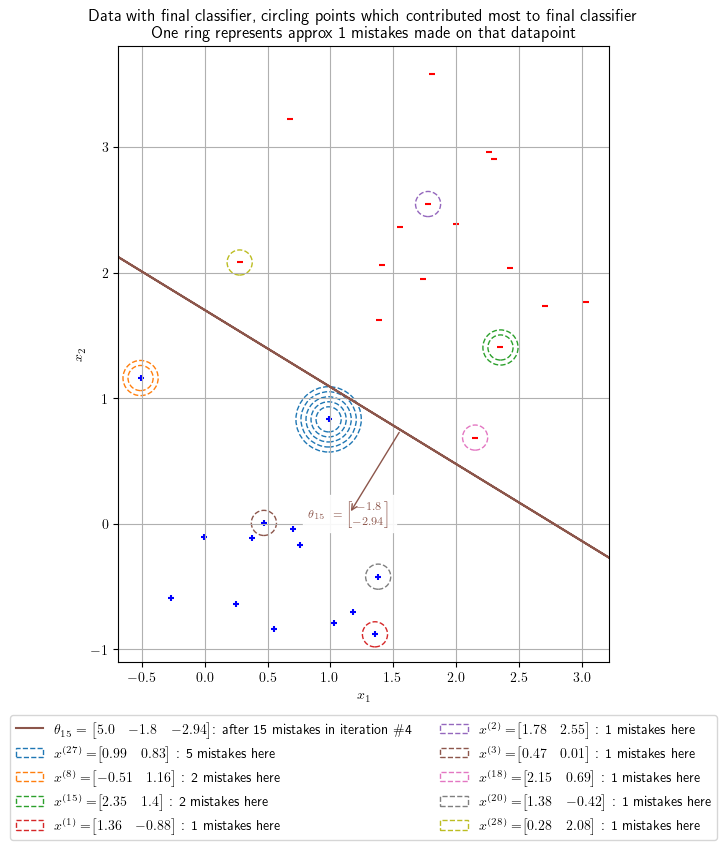

In [17]:
def graph_most_significant_datapoints(X, Y, importance_of_each_datapoint=None, final_theta=None, datapoint_alpha=1, ax=None):
    '''Shows how important each datapoint is to the final classifier by circling it accordingly.
    
    Given a dataset X, with corresponding labels Y, (and optionally importance_of_each_datapoint),
    shows data and final classifier, and draws circles around each datapoint according to the number of updates it caused.
    If importance_of_each_datapoint and final_theta aren't given, runs linear perceptron algorithm to find them.
    Allows classifiers with an intercept.

    Args:
        X           :  the dataset
        Y           :  the data labels
        importance_of_each_datapoint  :  a dataframe of all datapoints which caused updates, and how many times
        final_theta :  theta of the final classifier.
        datapoint_alpha   :  how opaque the datapoints should be (helps visibility of rings)
        ax          :  the axis to plot on

    Returns:
        ax          :  if ax is provided to the function, it returns the ax with all additions.
                        Otherwise it plots the axis and returns None.
    '''

    #if only X and Y are provided, run the perceptron algorithm
    if type(importance_of_each_datapoint)==type(None):
        theta, updates_newly_calculated = linear_perceptron(X, Y, verbose=0, return_updates_df=True)
        final_theta, importance_of_each_datapoint = summarise_most_significant_datapoints(updates_newly_calculated)
        total_num_iterations = updates_newly_calculated['iteration'].max()
        total_num_mistakes = updates_newly_calculated['mistake num'].max()
    else:
        total_num_iterations = updates['iteration'].max()
        total_num_mistakes = updates['mistake num'].max()

    if type(final_theta) == type(None):
        final_theta = np.sum(np.vstack(importance_of_each_datapoint['this_datapoints_effect']), axis=0)
        # print('final theta', final_theta)

    plot_ax = False

    if ax==None:
        figsize=(8, 8)
        fig, ax = plt.subplots(1,1, figsize=figsize)
        plot_ax = True

    #if there are points with loads of mistakes, we can't draw a circle for every mistake.
    #instead each circle must represent k mistakes (by default, k=1)
    max_mistakes_on_any_point = importance_of_each_datapoint['num mistakes on this data point'].max()
    if max_mistakes_on_any_point < 10:
        k=1
    else:
        k = max_mistakes_on_any_point / 7          # so max number of circles will be 7

    plot_data_on_ax(X, Y, ax, alpha=datapoint_alpha)
    ax.set_title('Data with final classifier, circling points which contributed most to final classifier'
    + '\nOne ring represents approx ' + str(round(k)) + ' mistakes made on that datapoint')
    dividing_line, theta_arrow, theta_text = plot_dividing_line_and_theta_arrow_on_ax(theta=final_theta, ax=ax, 
        num_mistakes=total_num_mistakes, t=total_num_iterations-1)

    # lets draw circles round points where errors happened. Multiple rings for points which caused multiple errors
    for row_i, point in enumerate(importance_of_each_datapoint.iterrows()):
        # print(point[0], point[1]['num mistakes on this data point'])
        i=point[1]['datapoint of mistake - num']-1
        plot_circle_on_ax(ax=ax,  circle_radius=.1, 
            X_i=X[i], i=i, 
            num_rings= int(np.ceil(point[1]['num mistakes on this data point'] / k)), 
            num_mistakes=point[1]['num mistakes on this data point'], 
            colour_num=row_i, annotation_or_legend='legend')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=2)# fancybox=True, shadow=True, ncol=5)

    if plot_ax:
        plt.show()
    else:
        return ax

final_theta, importance_of_each_datapoint = summarise_most_significant_datapoints(updates)

graph_most_significant_datapoints(X, Y, importance_of_each_datapoint)

## 5. Which datapoints are most likely to cause mistakes?

This is an important question, because those datapoints which cause mistakes are those which cause updates. Those datapoints which cause updates the most, are those which affect the final $\theta$ the most.  

Looking at the above plot gives the impression that datapoints which are near to the dividing line are more likely to be the cause of a mistake. Therefore those datapoints will play a much greater role in the decision of what the final classifier will be. Intuitively, do you think that makes sense?  

We can confirm this by looking at some larger samples:

In [18]:
def plot_multiple_examples(plot_func, centres=None, **kwargs):
    '''Plots the same function multiple times, each time using different centres to generate the X data.

    Given a function which plots data on an ax, generates data according to centres, and then plots the function once for each centre.

    Args:
        plot_func   :  the function which returns the desired plot
        centres     :  the centres for the data. If not provided, uses defaults as defined in the function.
        **kwargs    :  any arguments to pass to the plot_func.

    '''
    if type(centres) == type(None):
        centres = [
                    [[1,1], [-1,-1]],
                    [[-1,0.1], [1,0]],
                    [[-1,-.5], [1,.5]],
                ]

    num_plots = len(centres)
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(25,25))


    for plot_i in range(num_plots):
        np.random.seed(plot_i)
        n_samples=np.random.randint(low=500, high=1500)
        # centres_offset=np.random.uniform(low=-15, high=15, size=2)

        X_big_sample, Y_big_sample = generate_data(n_samples=n_samples, linearly_separable=True, centres=centres[plot_i])

        axes[plot_i]=plot_func(X_big_sample, Y_big_sample, ax=axes[plot_i], **kwargs)

        # remove legend and change title
        try:                        axes[plot_i].get_legend().remove()
        except AttributeError:      pass
        axes[plot_i].set_title(str(n_samples) + ' samples. Centres: ' +str(centres[plot_i]))


    plt.show()

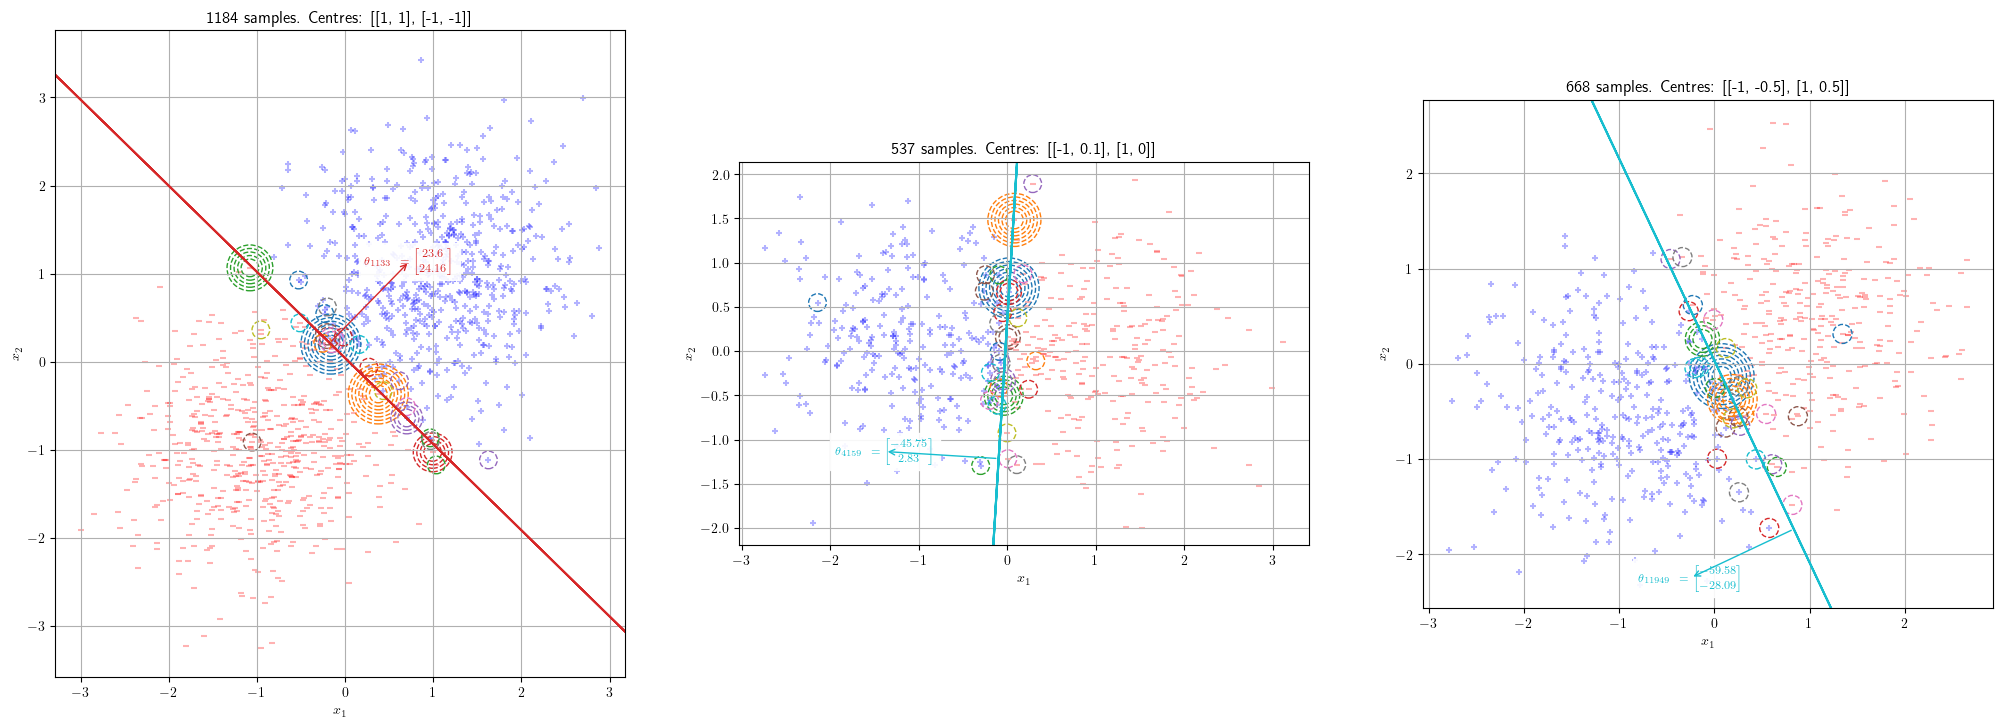

In [19]:
plot_multiple_examples(plot_func=graph_most_significant_datapoints, datapoint_alpha=.3)

Intuitively, it is to be expected that as the classifier will often be close to a good solution, the datapoints which cause the mistake will be those which are close to the correct solution. The above examples are really strong examples of this.  

Probablistically, whenever the classifier is far away, e.g. if it classifies all points in the dataset as positive, then all the negative points are equally likely to be the next point which causes the mistake. However a lot of the time the classifier is close to the truth, and when that happens the probability of being the cause of a mistake is split uniformly over only those points between where the classifier is and where it should be. So that biases updates in favour of those points near to the dividing line. (Although the linear perceptron is a deterministic process given the order of the data, this is still a useful way to think about why points near to the border are often the cause of mistakes).

Before scrolling down, take a moment to think: Will this effect always be so strong? What does the strength of this effect depend on? I.e. are there any factors *in the original dataset* which would make the "mistake datapoints" be more distributed over the entire dataset and not so strongly clustered around the final dividing line? Try to come up with a hypothesis before looking at the next set of plots.

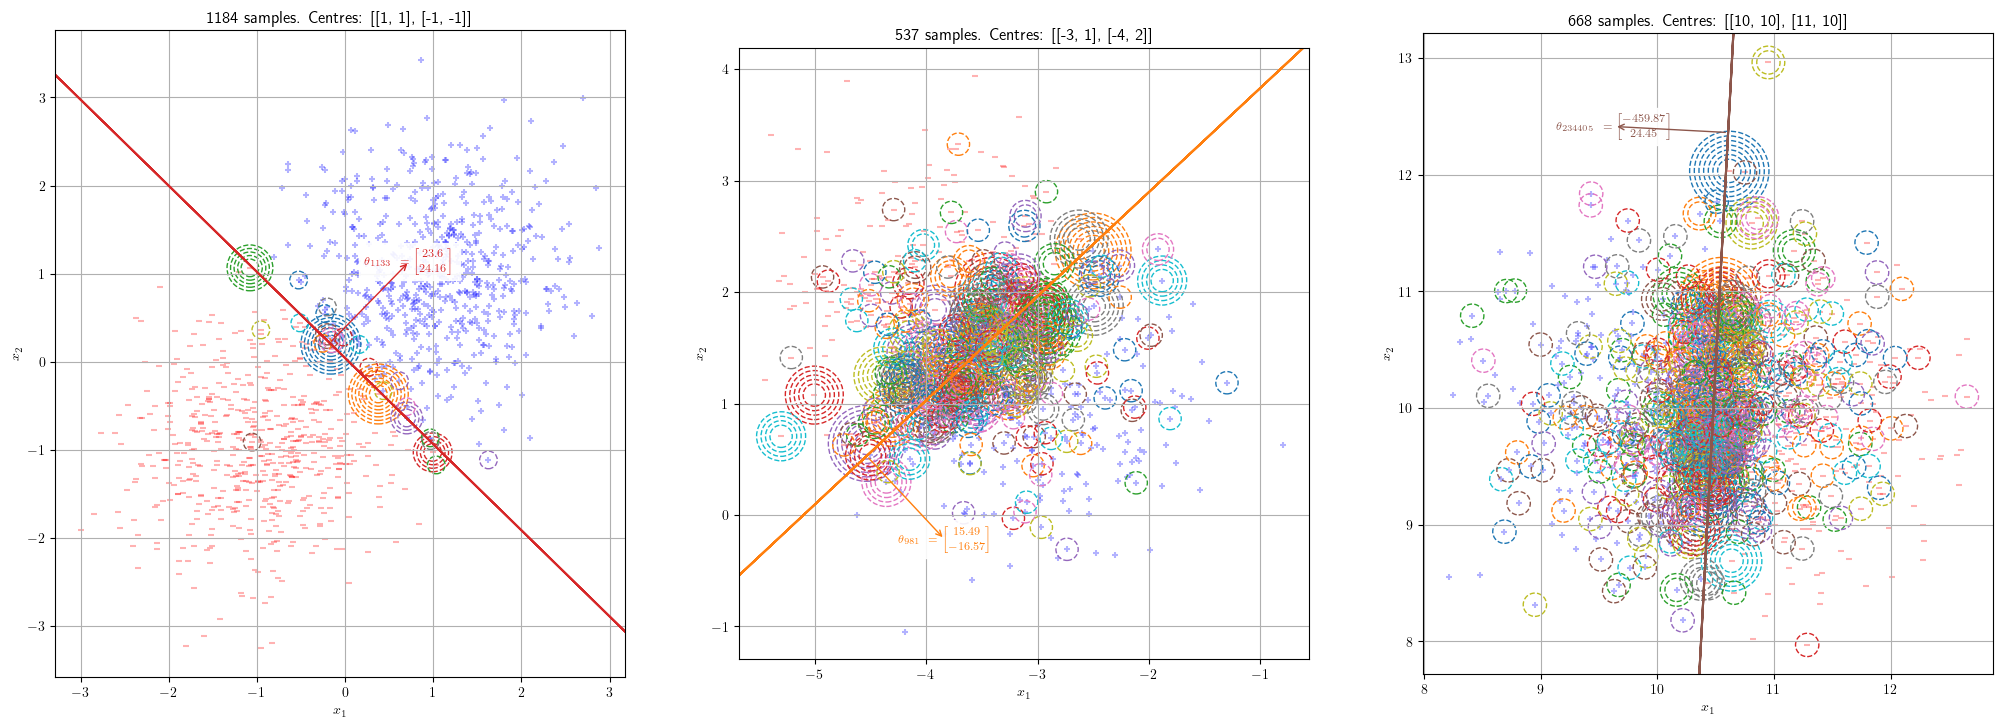

In [20]:
centres = [
            [[1,1], [-1,-1]],
            [[-3,1], [-4,2]],
            [[10,10], [11,10]],
         ]

plot_multiple_examples(plot_func=graph_most_significant_datapoints, centres=centres, datapoint_alpha=.3)

Looking at these plots, it is clear that in all of the plots, the points closest to the line do cause mistakes more frequently than those points which are further away. However this effect is much stronger in the first plot than it is in the last plot.  

Does this match your hypothesis?  

Feel free to connect with me on __[LinkedIn](https://www.linkedin.com/in/gabriel-kissin/)__ to suggest your explanation for this, or to hear what I think about it!

## 6. Cropping the dataset

Alice and Bob are two students of Professor Pamela's Data Science course. Prof Pam wants to test how comfortable they are with the linear perceptron process. So she asks her students the following question:  

> Suppose we have a linearly separable dataset with a large number of datapoints. We have already seen that some points are more likely to cause mistakes, and that those points are more important to the final classifier. So to increase computational efficiency, we propose it makes sense to crop the dataset, and choose a subset of the points which we hypothesize are most important. Then, we will run a slightly modified version of the linear perceptron algorithm: First, it will find a classifier using only the subset. Second, once it has converged on the subset, it will then start running through the entire dataset until it converges on the entire dataset.  
>
> How can we choose a subset of points which is most likely to get a classifier which is valid on the entire dataset after only running the first part - i.e. so that convergence on the subset is most likely to mean convergence on the entire dataset? We could simply select points randomly, but can we think of a better approach to this selection?
> 
(Although the stated (fake) purpose is to increase computational efficiency, Pamela explains that for the purpose of this question they shouldn't worry about the computational complexity of their procedure for cropping the dataset).  

The task is to produce a indices-producing function, which takes X and Y as input, and outputs an array of indices of specified length for the subset. That indices-producing function (which creates an array of subset indices) will then be fed as an input into the following comparison function. The comparison function will then graphically compare the classifier found using the entire dataset (green line), and the classifier found using the subset (orange line). The datapoints included in the subset are opaque, those not in the subset have a decreased opacity:


In [21]:
def compare_subset_to_full_dataset(X, Y, idx_selector, subset_size=0.1, ax=None, datapoint_alpha=0.2):
    '''Compares the results of the linear perceptron algorithm when run on the whole dataset vs when run on a subset.
    
    Given a dataset X, with corresponding labels Y, and a function `idx_selector` which returns indices for a subset,
    this function runs the linear perceptron algorithm on the entire dataset and then on the subset,
    and graphs both final classifiers together on one plot.
    Allows classifiers with an intercept.
    The green line is based on the whole dataset, whereas the orange line is based on the subset.
    
    Args:
        X           :  the dataset
        Y           :  the data labels
        idx_selector:  a function which takes exactly three arguments: X, Y, subset_size
                        and returns an array of indices which should comprise the subset.
        subset_size :  how large the subset should be.
                        If subset_size isn't specified, will do a tenth of the dataset. 
                        If subset_size <1, will do that fraction of the dataset.
                        subset_size >= 1, will use that many datapoints in the subset.
        ax          :  the axis to plot on
        datapoint_alpha   :  how opaque the datapoints which are NOT in the subset should be 
                        (helps visibility of datapoints which ARE in subset, which are fully opaque).

    Returns:
        ax          :  Returns the ax with all additions.
    '''

    if subset_size<1:
        subset_size = int(len(X) * subset_size)

    idxs = idx_selector(X, Y, subset_size)

    #plot data: subset is opaque, rest of data has alpha datapoint_alpha (default=.2)
    plot_data_on_ax(X[idxs], Y[idxs], ax=ax, alpha=1)
    plot_data_on_ax(X, Y, ax=ax, alpha=datapoint_alpha)

    #plot dividing lines for subset and entire dataset
    theta_subset = linear_perceptron(X[idxs], Y[idxs])
    plot_dividing_line_and_theta_arrow_on_ax(ax=ax, theta=theta_subset, num_mistakes=1)

    theta_alldata = linear_perceptron(X, Y)
    plot_dividing_line_and_theta_arrow_on_ax(ax=ax, theta=theta_alldata, num_mistakes=2)

    #draw circle around the points which are incorrectly classified by theta_subset
    # for i in range(len(X)):
    #     if (np.hstack([[0], X[i]]) @ theta_subset) <= 0 :
    #         plot_circle_on_ax(ax=ax, X_i=X[i],i=i)

    return ax


#### Approach #0: Random choice of datapoints for subset (baseline)

In [22]:
def random_subset_indices(X, Y, subset_size):
    '''Randomly chooses indices from X.

    Args:
        X           :  the dataset
        Y           :  the data labels (not used in this function, retained for uniformity)
        subset_size :  an integer stating how many indices to choose
    
    Returns:
        random_idxs :  indices randomly chosen from X (length subset_size)
    '''

    random_idxs = np.random.choice(np.arange(len(X)), size=subset_size, replace=False)
    return random_idxs

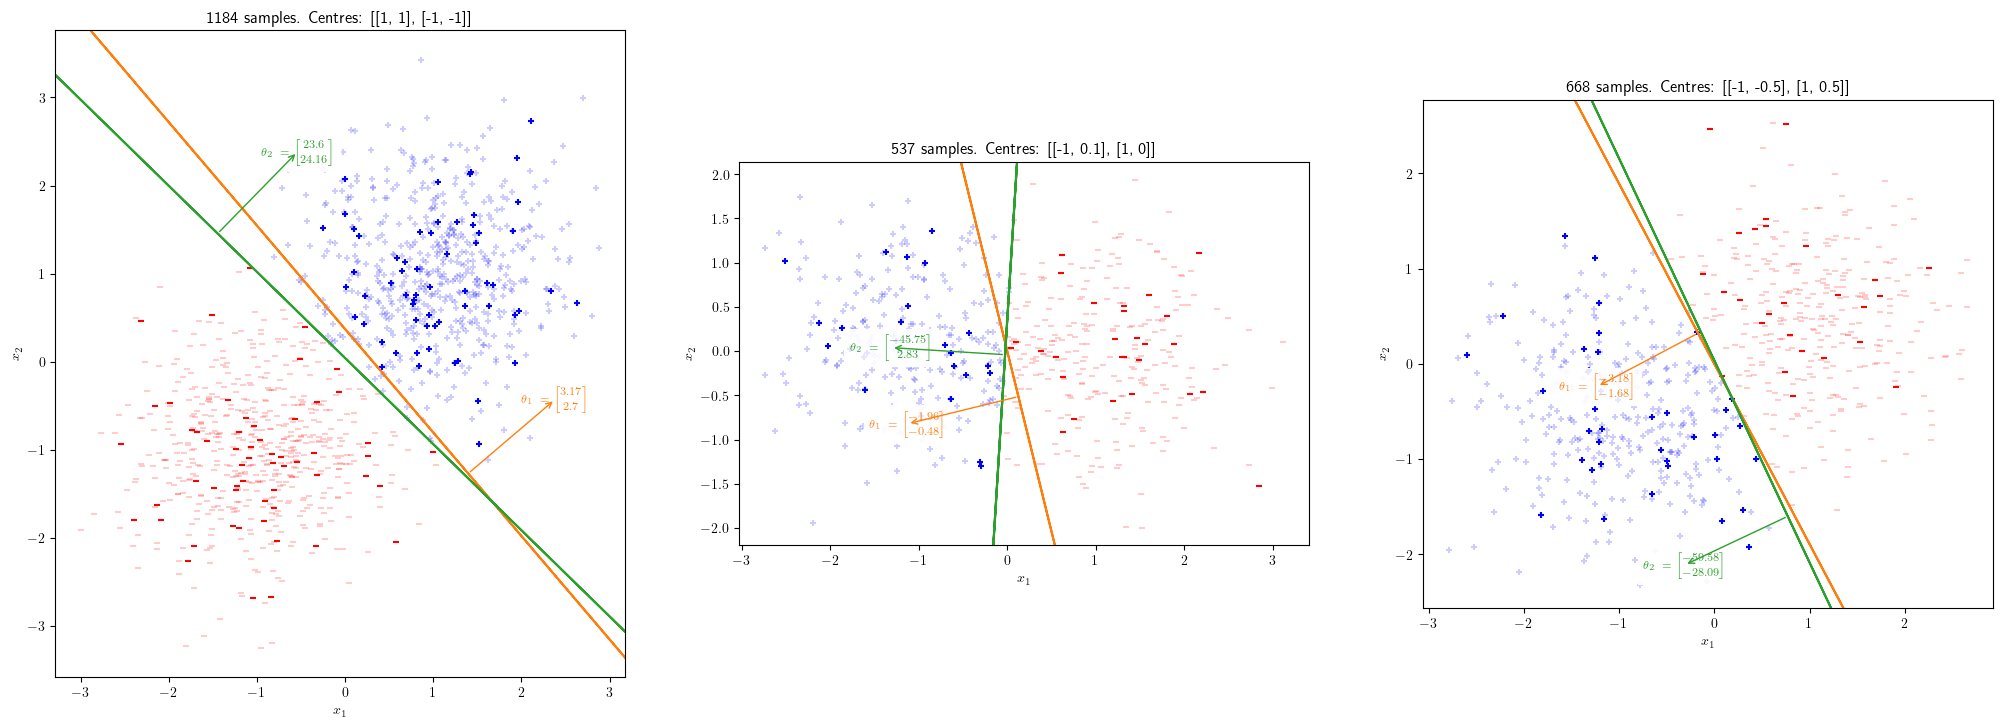

In [23]:
plot_multiple_examples(plot_func=compare_subset_to_full_dataset, idx_selector=random_subset_indices)

So random sampling doesn't produce a very impressive classifier.

#### Approach #1: Pamela (flawed)
To start the ball rolling, Pamela describes a simple but very flawed approach. Suppose we were to choose those points closest to the mean of the entire dataset as a subset. Doesn't it stand to reason that those points will tend to be closer to the final line than randomly chosen points would be? And therefore they would make a good choice for the subset?  


In [24]:
import scipy.spatial.distance

def closest_to_data_centre_subset_indices(X, Y, subset_size):
    '''Chooses indices from X according to their proximity to the mean of the data.

    Args:
        X           :  the dataset
        Y           :  the data labels (not used in this function, retained for uniformity)
        subset_size :  an integer stating how many indices to choose
    
    Returns:
        most_central_idxs :  indices chosen from X (length subset_size)
    '''
    dists_from_mean = scipy.spatial.distance.cdist(XA=np.mean(X, axis=0).reshape((1,-1)), XB=X, metric='euclidean').flatten()
    most_central_idxs = np.argsort(dists_from_mean)[:subset_size]
    return most_central_idxs



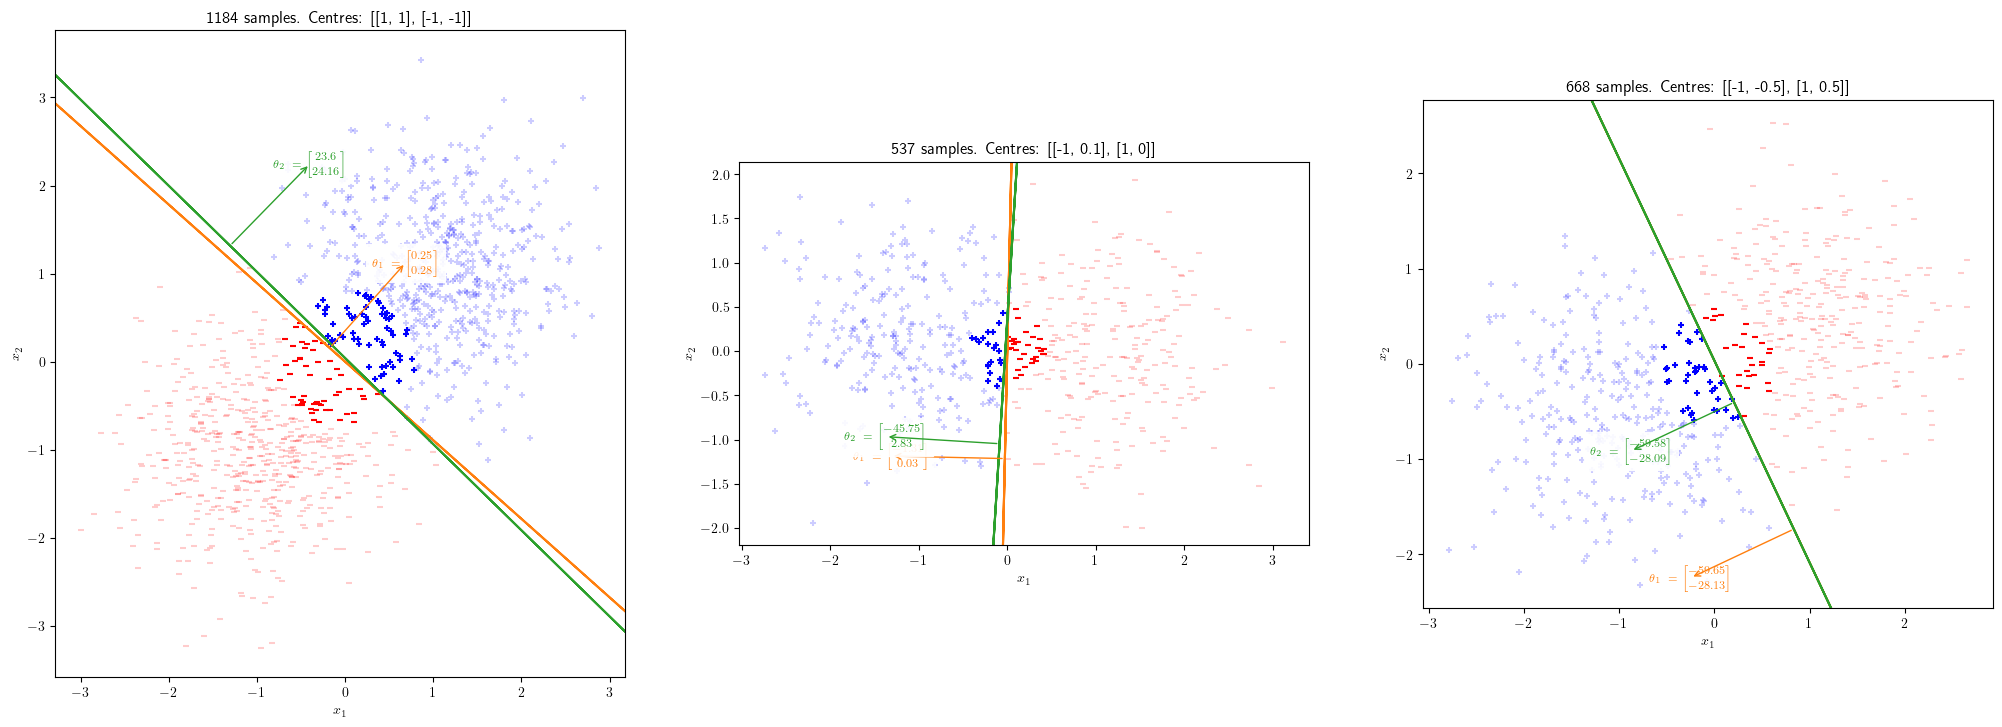

In [25]:
plot_multiple_examples(plot_func=compare_subset_to_full_dataset, idx_selector=closest_to_data_centre_subset_indices) 

#### Approach #2: Alice

Although the above graphs look quite good, Alice thinks carefully and quickly realises that the above approach has two major flaws:  
1) By prioritising points near the data mean, we ignore points further out even if they are close to the dividing line. In defining the dividing line, all points near the *line* are important, not points near the data centre. This is particularly important when data isn't Gaussian.  
2) More importantly, the approach of looking at the data mean would only work at all when the mean is between the two classes. In the above examples, there are two clusters with roughly the same number of datapoints, and roughly the same shape. So the mean is indeed between the two classes, meaning that it works reasonably well. However if one cluster would be much larger than the other, then the mean would be within the larger cluster - so only points from the larger cluster would be selected, and those points won't be close to the divide.  

Instead, Alice writes a function which chooses points according to their proximity to the other cluster. To measure proximity to the other cluster, she doesn't use the mean of the other cluster, but the closest point in the other cluster. In other words, we go through all the datapoints; for datapoint i, we calculate its distance to all the datapoints of the opposite class; and we find the minimum distance. We then say that datapoint i's proximity to the other cluster is given by that minimum value.  

Alice argues that this approach avoids the two problems above, because 1) we don't look only at points near the data mean, and 2) we select points which are near the divide.

In [26]:
def closest_to_opposite_cluster_subset_indices(X, Y, subset_size):
    '''Chooses indices from X according to their proximity to the nearest point of the opposite cluster.

    Args:
        X           :  the dataset
        Y           :  the data labels (not used in this function, retained for uniformity)
        subset_size :  an integer stating how many indices to choose
    
    Returns:
        most_near_to_point_of_opposite_cluster_idxs :  indices chosen from X (length subset_size)
    '''

    X_plus  = X[Y==+1]
    X_minus = X[Y==-1]

    dists_matrix = scipy.spatial.distance.cdist(XA=X_plus, XB=X_minus, metric='euclidean')

    X_plus_min_dist  = np.min(dists_matrix, axis=1)
    X_minus_min_dist = np.min(dists_matrix, axis=0)

    dists_from_nearest_point_of_opposite_cluster = np.zeros_like(Y).astype(float)
    dists_from_nearest_point_of_opposite_cluster[Y==+1] = X_plus_min_dist
    dists_from_nearest_point_of_opposite_cluster[Y==-1] = X_minus_min_dist

    most_near_to_point_of_opposite_cluster_idxs = np.argsort(dists_from_nearest_point_of_opposite_cluster)[:subset_size]
    
    return most_near_to_point_of_opposite_cluster_idxs


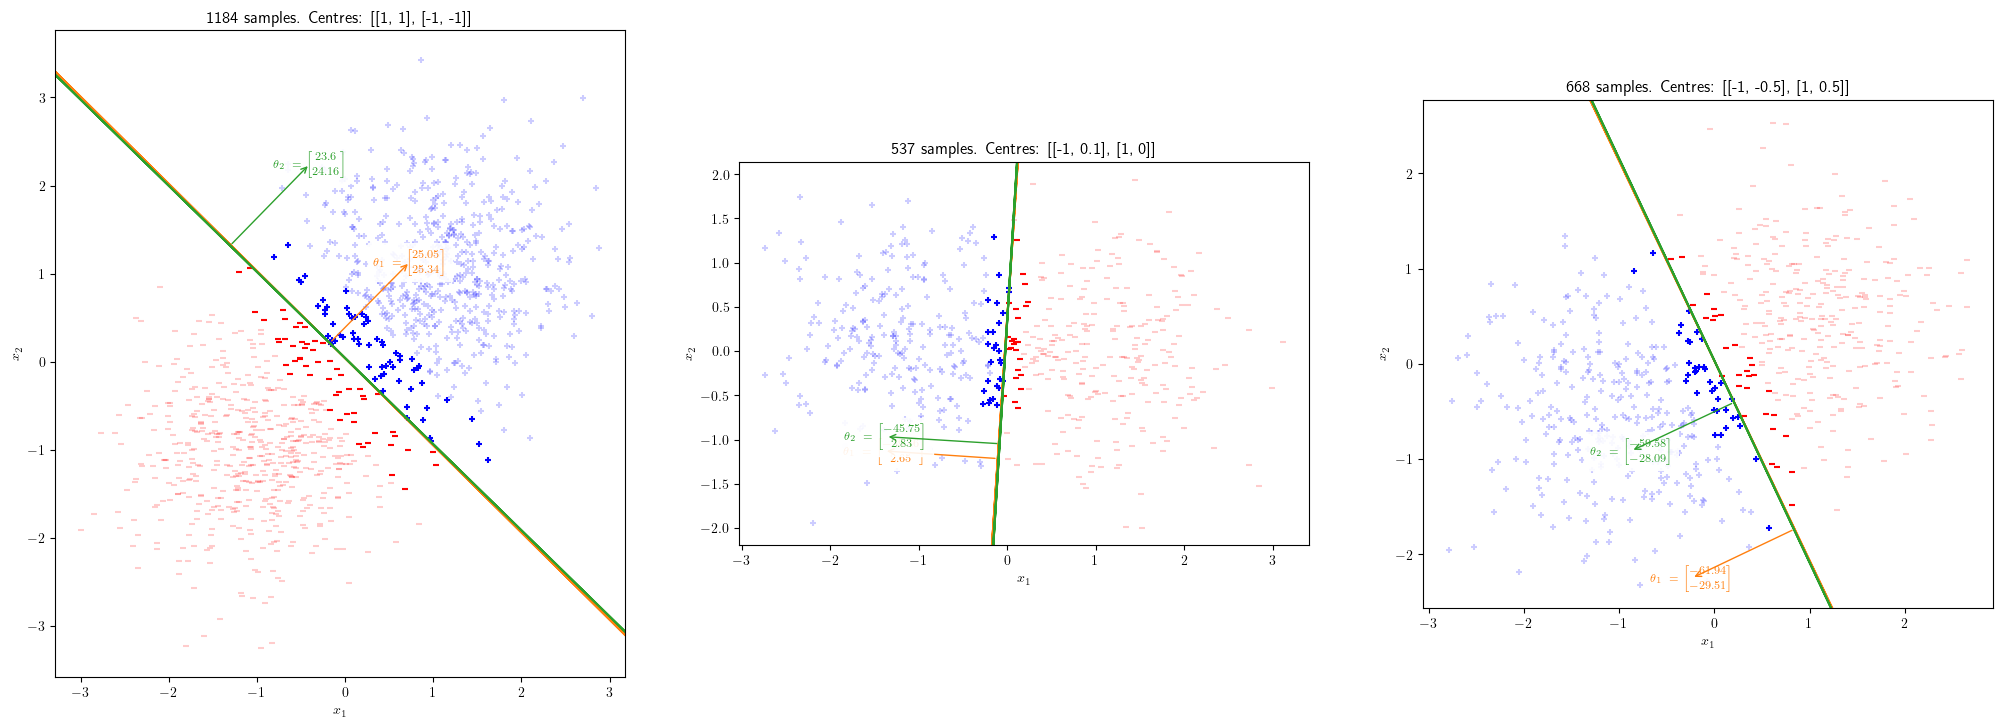

In [27]:
plot_multiple_examples(plot_func=compare_subset_to_full_dataset, idx_selector=closest_to_opposite_cluster_subset_indices)

#### Approach #3: Bob

Bob, like Alice, also saw the two major flaws in Prof Pam's suggestion. But Bob comes up with a rather devious alternative. He will simply run the perceptron algorithm on the entire dataset to find a linear classifier. Then, the datapoints closest to that dividing line will be selected for the subset! No need to calculate the matrix of distances between the points of different classes.  

Bob reasons that this approach would also avoid the two problems with Prof Pam's approach, because again 1) we don't look only at points near the data mean, and 2) we select points which are near the divide.

In [28]:
def closest_to_dividing_line_subset_indices(X, Y, subset_size):
    '''Chooses indices from X according to their proximity to the dividing line of the perceptron algorithm.

    Args:
        X           :  the dataset
        Y           :  the data labels (not used in this function, retained for uniformity)
        subset_size :  an integer stating how many indices to choose
    
    Returns:
        most_near_to_dividing_line_idxs :  indices chosen from X (length subset_size)
    '''

    theta = linear_perceptron(X, Y)

    X_with_ones_prefixed = np.hstack([np.ones((X.shape[0], 1))   ,   X ])

    dists_from_dividing_line = (X_with_ones_prefixed @ theta.reshape((-1,1))).flatten()   *   Y

    assert (dists_from_dividing_line>0).all()
    # if not (dists_from_dividing_line>0).all():
    #     print()
    #     print(dists_from_dividing_line[dists_from_dividing_line<=0])
    #     print(X[dists_from_dividing_line<=0])
    #     print(X_with_ones_prefixed[dists_from_dividing_line<=0]  @ theta.reshape((-1,1)) )
    #     print(Y[dists_from_dividing_line<=0])

    most_near_to_dividing_line_idxs = np.argsort(dists_from_dividing_line)[:subset_size]
    
    return most_near_to_dividing_line_idxs


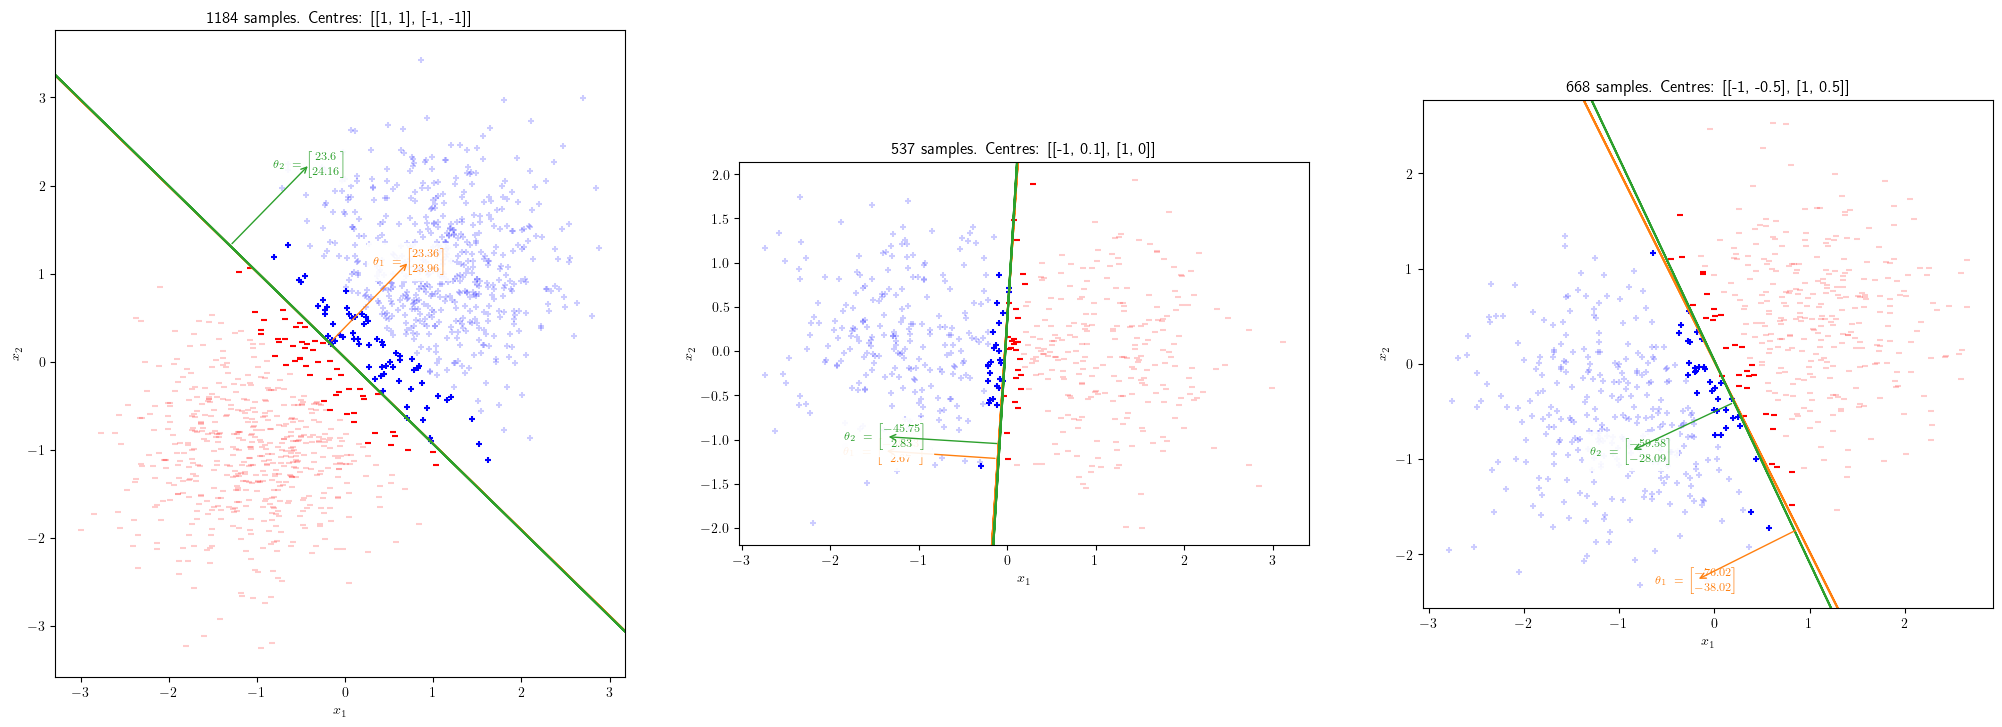

In [29]:
plot_multiple_examples(plot_func=compare_subset_to_full_dataset, idx_selector=closest_to_dividing_line_subset_indices) 

Professor Pamela is pleased with both of these suggestions. She asks Bob to think more about his method, using Euclidean distance from the dividing line, and whether Euclidean distance is the most appropriate measure here. Perhaps we should instead be looking at angles - i.e. choose some point on the dividing line, draw lines from that point to all the datapoints, and consider which point's line has the smallest *angular* distance from the dividing line.  

Then she turns to **you**, her prize student. What do *you* think? she asks. Which method is best? What drawbacks do each of the methods have? 
 
Can you design a better method? What is the minimal number of datapoints you need in the subset to guarantee finding a classifier which will correctly classify the entire dataset, and how can those datapoints be identified?  

She gives you a hint: try to think of different dataset shapes on which the various methods might not work so well. And what might happen as the size of the subset decreases in all of the methods. As a quick visualisation, she writes a function for the 'angular distance from dividing line' approach and shows what happens as subset size decreases:  

#### Approach #4: Professor Pamela again - angular distance from dividing line

In [30]:
def smallest_angular_distance_subset_indices(X, Y, subset_size):
    '''Chooses indices from X according to their *angular* proximity to the dividing line of the perceptron algorithm.

    Indices are chosen from X as follows:
    First we find a dividing line using linear perceptron. Then,
    1. points from the plus class are chosen - 
        - we choose those where the *angle* between them and the line is closest to zero, as those points restrict the line the most
    2. points are chosen from the minus class, again where the angle is closest to zero

    Args:
        X           :  the dataset
        Y           :  the data labels (not used in this function, retained for uniformity)
        subset_size :  an integer stating how many indices to choose
    
    Returns:
        smallest_angles :  indices chosen from X (length subset_size)
    '''

    theta = linear_perceptron(X, Y)
    point_on_dividing_line = [0, -theta[0]/theta[2]]
    # print('\npoint_on_dividing_line', point_on_dividing_line)

    plus_idxs  = np.arange(len(X))[Y==+1]
    minus_idxs = np.arange(len(X))[Y==-1]

    a_plus = (X[plus_idxs] - point_on_dividing_line) @ (theta[-2:].reshape((-1,1))).flatten()
    smallest_angles_plus = np.argsort(np.abs(a_plus))

    a_minus = (X[minus_idxs] - point_on_dividing_line) @ (theta[-2:].reshape((-1,1))).flatten()
    smallest_angles_minus = np.argsort(np.abs(a_minus))

    smallest_angles = np.hstack([ plus_idxs[smallest_angles_plus[:int(np.ceil(subset_size/2))]],    minus_idxs[smallest_angles_minus[:int(np.ceil(subset_size/2))]] ])

    return smallest_angles



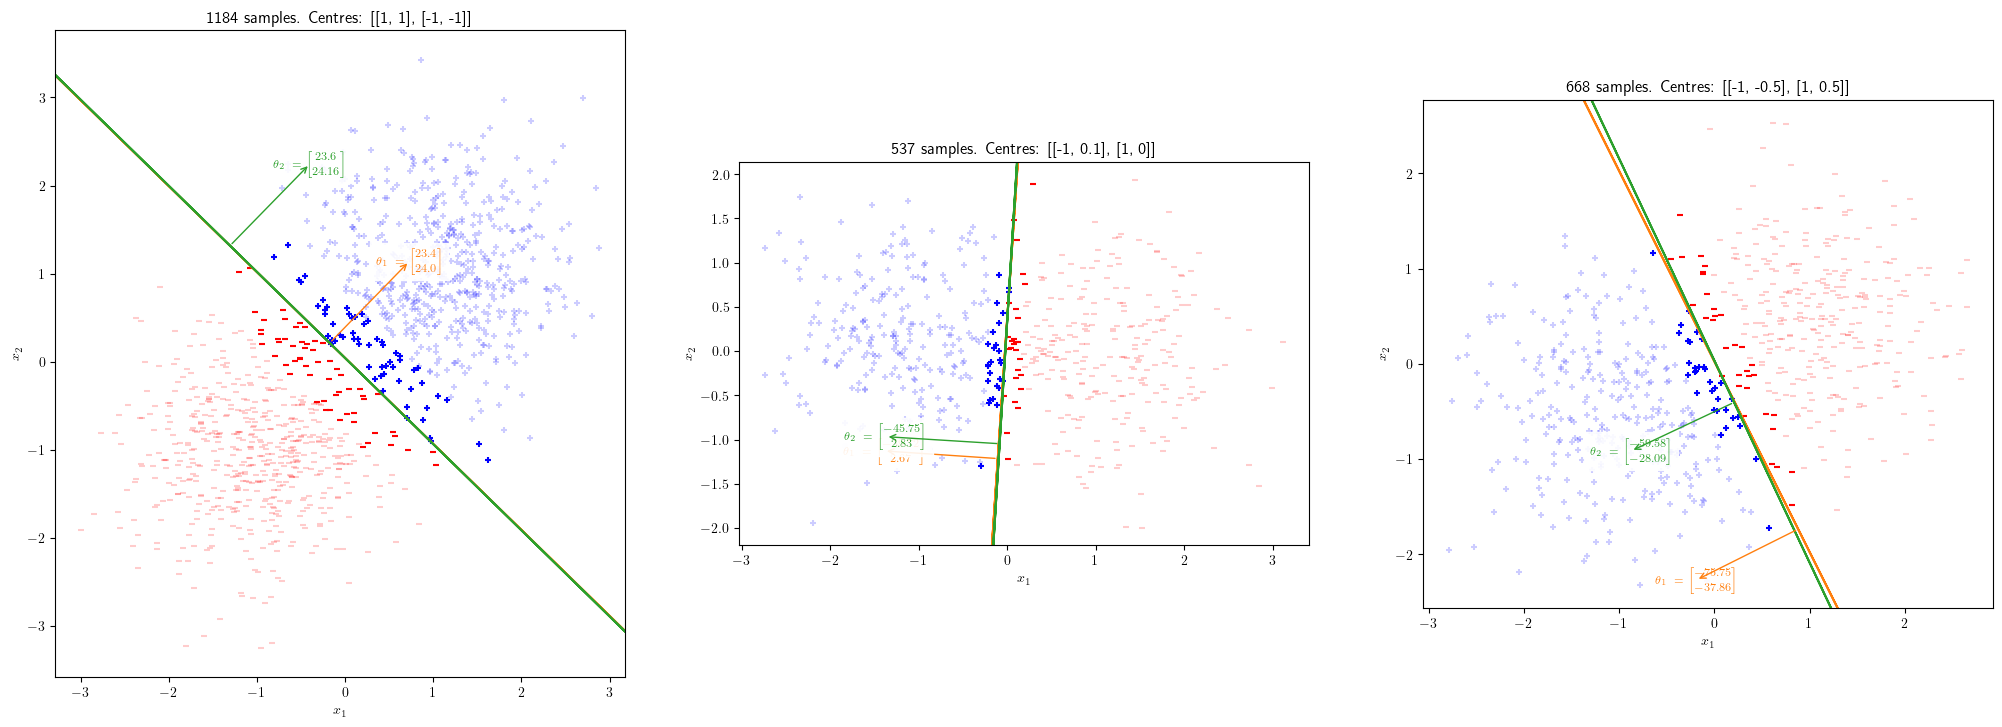

In [31]:
plot_multiple_examples(plot_func=compare_subset_to_full_dataset, idx_selector=smallest_angular_distance_subset_indices,) 

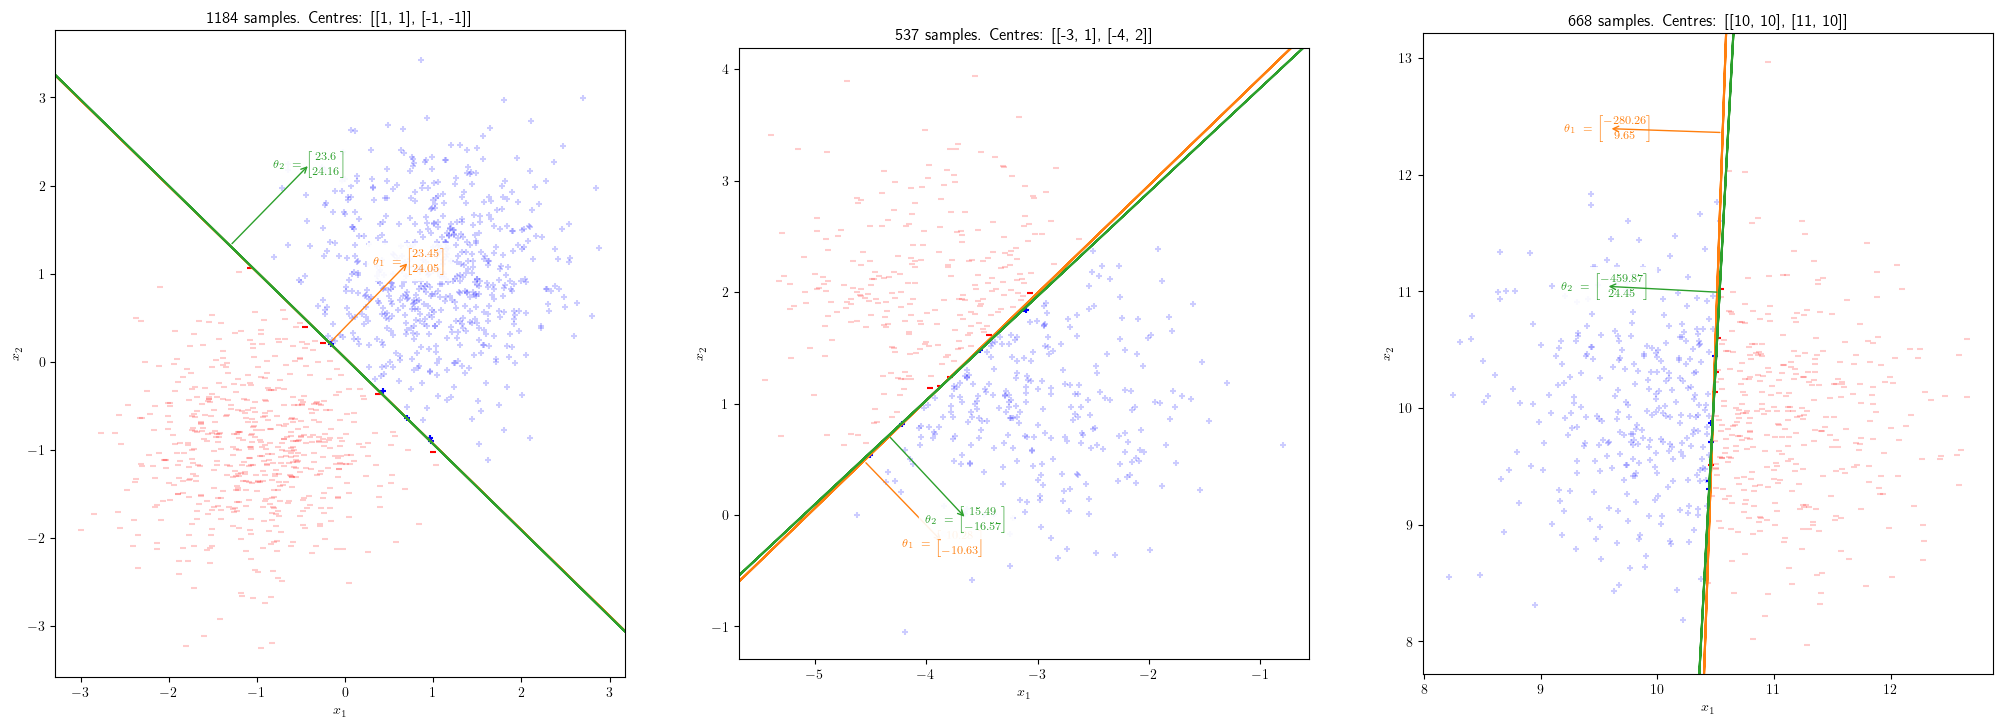

In [32]:
plot_multiple_examples(plot_func=compare_subset_to_full_dataset, 
    idx_selector=smallest_angular_distance_subset_indices, centres=centres, subset_size=10) 

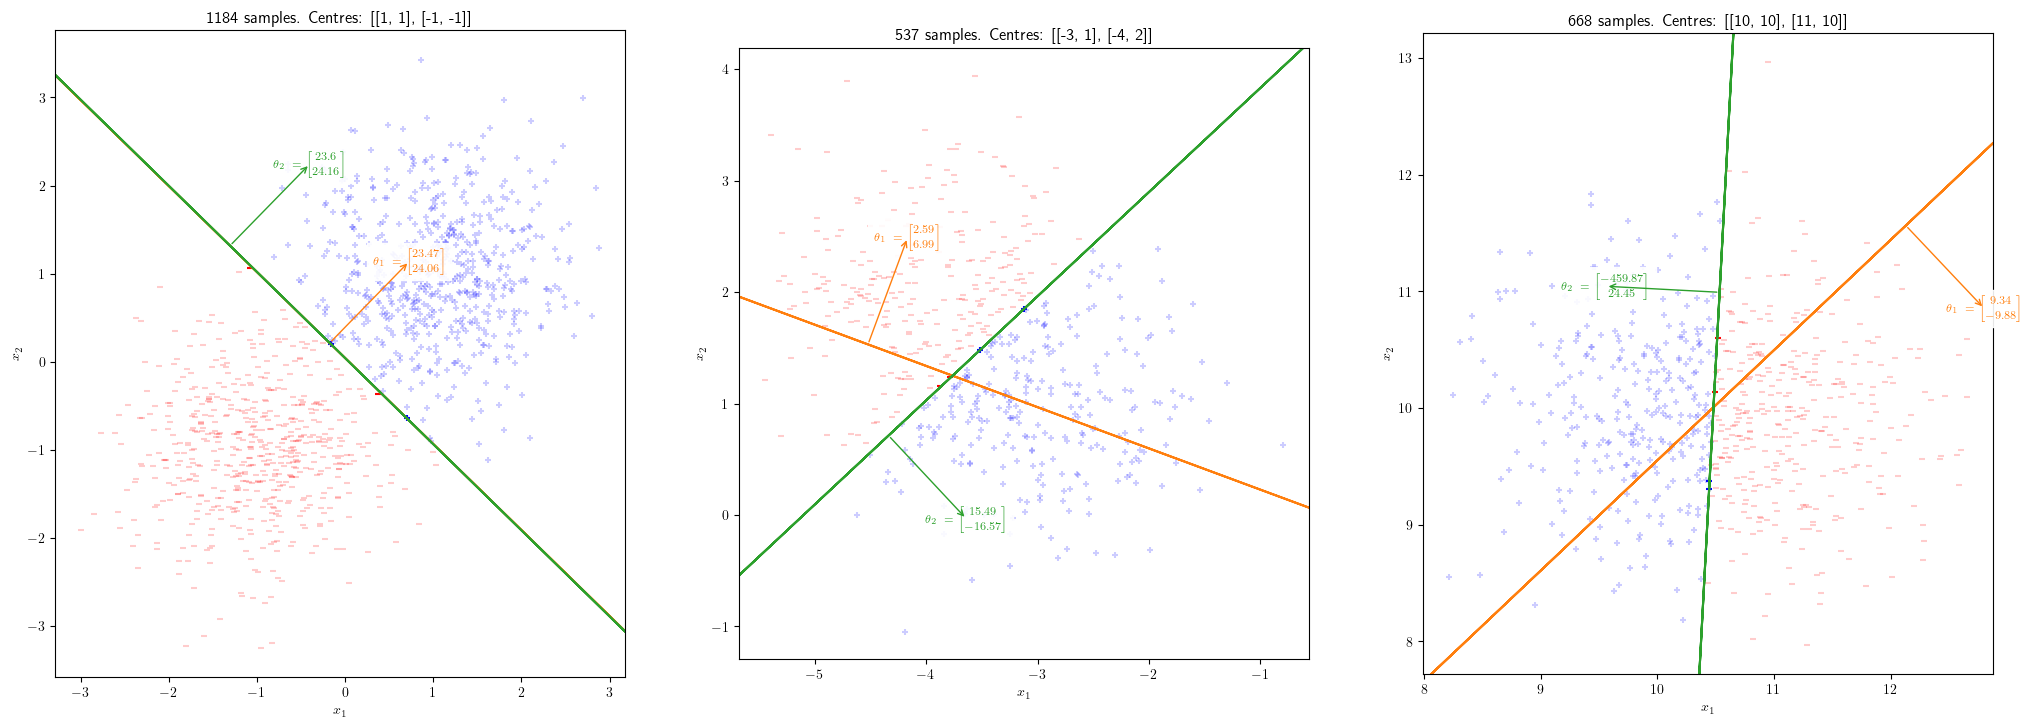

In [33]:
# an example where this approach doesn't work, for reasons which will be clear upon inspection
plot_multiple_examples(plot_func=compare_subset_to_full_dataset, idx_selector=smallest_angular_distance_subset_indices, centres=centres, subset_size=4) 

So when subset size goes down to 4, the 'angular distance from dividing line' method doesn't do very well.  

How about the other approaches?  

What can be done about this?  

Let me know your thoughts... and again you are welcome to connect via __[LinkedIn](https://www.linkedin.com/in/gabriel-kissin/)__. Hope you enjoyed this notebook!